# **Example AWARE | Use case 1**

**Authors:**
[Romain Sacchi](mailto:romain.sacchi@psi.ch)
[Alvaro Hahn Menacho](mailto:alvaro.hahn-menacho@psi.ch)

This notebook presents an example to obtain an exchange-based LCA score using the [AWARE 2.0](https://wulca-waterlca.org/aware/) method.
This example is part of the following publication:

**Sacchi, R., Menacho, A. H., Seitfudem, G., Agez, M., Schlesinger, J., Koyamparambath, A., Saldivar, J. S., Loubet, P., & Bauer, C.** (2025). *Contextual LCIA Without the Overhead: An Exchange-based Framework for Flexible Impact Assessment.*
International Journal of Life Cycle Assessment.


## Structure

1. [Import *edges* and set *bw2 project*](#sec_import_edges)
2. [Import hydrogen production, PEM, LCI](#sec_import_h2)
3. [Select *Functional Unit* and *method*](#sec_select_fu)
4. [Run edges based LCA](#sec_run_edges_lca)
5. [Export results](#sec_export_results)
6. [Plot results](#sec_plot_results)

<a id="sec_import_edges"></a>
# 1. Import the ``edges`` and set up a ``brightway`` project

In [1]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import logging
import bw2data, bw2io

# we want the logger to log things into edges.log
setup_package_logging(level=logging.INFO)
# if you want full debug:
#setup_package_logging(level=logging.DEBUG)

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


13:02:30+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


For our example, we activate a ``brighway`` project that contains ecoinvent 3.10 cut-off.

In [2]:
# bw2data.projects.set_current("bw25_ei310")
bw2data.projects.set_current("ecoinvent-3.10-cutoff")

<a id="sec_import_h2"></a>
# 2. Import hydrogen production, PEM, LCI

To illustrate our water footprint case, we need to import some inventories representing the production of hydrogen using a PEM electrolyzer, powered with offshore wind power in France. The inventories are provided in this repository (``lci-hydrogen-electrolysis-ei310.xlsx``).

In [5]:
if "h2_pem" in bw2data.databases:
    del bw2data.databases["h2_pem"]
lci = bw2io.ExcelImporter("lci-hydrogen-electrolysis-ei310.xlsx")
lci.apply_strategies()
lci.match_database(fields=["name", "reference product", "location"])
lci.match_database("ecoinvent-3.10-cutoff",fields=["name", "reference product", "location"])
lci.match_database("ecoinvent-3.10-biosphere",fields=["name", "categories"])
lci.statistics()
lci.drop_unlinked(i_am_reckless=True)
if len(list(lci.unlinked)) == 0:
    lci.write_database()

# we assign manually classifications to activities
# since it is unclear how to do that in the Excel inventory file.

classifications = {
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from solar photovoltaic electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from onshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from geothermal electricity": ("CPC", "34210"),
    "electrolyzer production, 1MWe, PEM, Stack": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer stack, 1MWe, PEM": ("CPC", "3830"),
    "electrolyzer production, 1MWe, PEM, Balance of Plant": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer balance of plant, 1MWe, PEM": ("CPC", "3830"),
    "platinum group metal, extraction and refinery operations": ("CPC", "2420"),
    "deionized water production, via reverse osmosis, from brackish water": ("CPC", "34210")
}
for ds in bw2data.Database("h2_pem"):
    if ds["name"] in classifications:
        ds["classifications"] = [classifications[ds["name"]]]
        ds.save()


Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.07 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Graph statistics for `h2_pem` importer:
11 g

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 652.74it/s]

19:03:17+0200 [info     ] Vacuuming database            


Created database: h2_pem


<a id="sec_select_fu"></a>
# 3. Select Functional Unit and method

### 3.1. Select FU
We select the activity to run the LCA for. In our case, it is the production of 1 kg of hydrogen, using a PEM electrolyzer, powered with offshore wind power, in France.

In [3]:
act = [a for a in bw2data.Database("h2_pem") if a["name"] == "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity"][0]
act

'hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity' (kilogram, FR, None)

### 3.2. Select method
``edges`` comes with a numbers of LCIA methods. You can list them using the `get_available_methods()` function.
We currently have four flavors of `AWARE` 2.0:

* 'AWARE 2.0', 'Country', 'all', 'yearly'
* 'AWARE 2.0', 'Country', 'irri', 'yearly'
* 'AWARE 2.0', 'Country', 'non', 'irri', 'yearly'
* 'AWARE 2.0', 'Country', 'unspecified', 'yearly'

All four variants provide characterization factors (CFs) at the country level.
The `irri`, `non-irri`, and `unspecified` methods distinguish between water consumption patterns: irrigation-related, non-irrigation-related, and activities where the type of consumption is unknown. This discrimination is based on CPC classification codes of the activities.

The `all` method bundles these three variants into a single method: for each CF, it provides separate factors for irrigation-related consumers (e.g., farming, crop cultivation), non-irrigation activities, and cases where the consumption type cannot be specified.

For more information about its implementation and use, refer to [the page about](https://edges.readthedocs.io/en/latest/methods.html#aware-2-0) AWARE in the ``edges`` documentation, and for more information about the AWARE method itself, refer to:

**Seitfudem, G., Berger, M., Schmied, H. M., & Boulay, A.-M. (2025)**. *The updated and improved method for water scarcity impact assessment in LCA, AWARE2.0*. Journal of Industrial Ecology, 29, 891–907. https://doi.org/10.1111/jiec.70023


In [4]:
get_available_methods()

[('AWARE 2.0', 'Country', 'all', 'yearly'),
 ('AWARE 2.0', 'Country', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'non', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'unspecified', 'yearly'),
 ('GeoPolRisk', 'elementary flows', '2024'),
 ('GeoPolRisk', 'paired', '2024'),
 ('GeoPolRisk', 'paired', '2024', 'short'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, long term', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, long term', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, short term', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, short term', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Land

In [4]:
method = ('AWARE 2.0', 'Country', 'all', 'yearly')
method

('AWARE 2.0', 'Country', 'all', 'yearly')

<a id="sec_run_edges_lca"></a>
# 4. Run edges-based LCA

In [5]:
# we instantiate EdgeLCIA, which builds on the `bw2calc.LCA` class
LCA = EdgeLCIA(
    demand={act: 1}, # <- we define a functional unit
    method=method, # <- we specify the LCIA method
    use_distributions=True, # <- we wnat to consider variability across watersheds
    iterations=10000 # <- we specific the number of iterations
)

# we solve the system
LCA.lci()

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


`.map_exchanges()` will try to find direct matches based on the criteria listed in the LCIA file.

In [6]:
LCA.map_exchanges()

Mapping exchanges: 100%|███████████████████| 9960/9960 [01:38<00:00, 101.28it/s]


The four following functions are specific to regionalized LCIA methods (which is the case here).

* ``map_aggregate_locations()``: It computes weighted averages for composite regions using a user-specified weighting variable (e.g., population, GDP, resource use) from the method metadata, e.g., RER.
* ``map_dynamic_locations()``: Handle location-matching for dynamic or relative regions such as ‘RoW’ or ‘RoE’.
* ``map_contained_locations()``: Resolve unmatched exchanges by assigning CFs from spatially containing regions (e.g., "CA-QC" will be given the CF for "CA")
* ``map_remaining_locations_to_global()``: Assign global fallback CFs to exchanges that remain unmatched after all regional mapping steps.

In [7]:
LCA.map_aggregate_locations()
LCA.map_dynamic_locations()
LCA.map_contained_locations()
LCA.map_remaining_locations_to_global()

Processing static groups (pass 1): 100%|███████| 10/10 [00:00<00:00, 389.74it/s]
US-PR not found in regex
IN-DD not found in regex
Processing contained groups (pass 1): 100%|██████| 4/4 [00:00<00:00, 580.29it/s]


When the mapping is done, the CFs can be evaluated. In this case, random samping of watersheds' CF for each country are drawn (10_000 times). When the LCIA methods only contain numeric values, the evaluation step is straigthfroward. However, in some cases, the CF value can be symbolic or rely on an external function call.

In [8]:
LCA.evaluate_cfs()

We can check, for example, which exchanges have been mapped to the last CF in our LCIA method.

In [9]:
LCA.cfs_mapping[-1]

{'supplier': {'categories': ('natural resource', 'in water'),
  'name': 'Water, well, in ground',
  'matrix': 'biosphere'},
 'consumer': {'location': 'US-HICC',
  'classifications': [('ISIC rev.4 ecoinvent',
    '0990:Support activities for other mining and quarrying'),
   ('CPC', '8')],
  'matrix': 'technosphere'},
 'positions': [(622, 8649)],
 'direction': 'biosphere-technosphere',
 'value': '(1.000 * (37.4))',
 'uncertainty': {'distribution': 'lognorm',
  'parameters': {'shape_a': 1.886,
   'loc': 0.1,
   'scale': 12.02,
   'minimum': 0.1,
   'maximum': 100.0},
  'negative': 0}}

Finally, we multiply the randomly sampled CF values with the amounts from the inventory matrix.

In [10]:
LCA.lcia()

We can see the 10_000 iterations' results.

In [11]:
print(LCA.score.data)

[0.68489303 0.67859773 1.06219685 ... 0.61010763 0.91121477 0.69901499]


<a id="sec_export_results"></a>
# 5. Export results

We can export the list of exchanges from the solved system.
We can include or not the exchanges that have not received a CF.

In [14]:
df_table = LCA.generate_cf_table(include_unmatched=False)

In [15]:
df_table.to_excel("AWARE_results_25.xlsx")

We can also print some statistics.

In [16]:
LCA.statistics()

+----------------------+--------------------------------------------+
|       Activity       | hydrogen production, gaseous, 30 bar, from |
|                      |    PEM electrolysis, from offshore wind    |
|                      |                electricity                 |
|     Method name      | ('AWARE 2.0', 'Country', 'all', 'yearly')  |
|         Unit         |           m3 deprived water-eq.            |
|      Data file       |        AWARE 2.0_Country_all_yearly        |
|    CFs in method     |                    9960                    |
|       CFs used       |                    5726                    |
|   Unique CFs used    |                    342                     |
|  Exc. characterized  |                    8898                    |
| Exc. uncharacterized |                   327074                   |
+----------------------+--------------------------------------------+


In [ ]:
LCA.statistics()

<a id="sec_plot_results"></a>
# 6. Plot results
Script used to produce Figure 2 in the Sacchi et al. 2025 article.

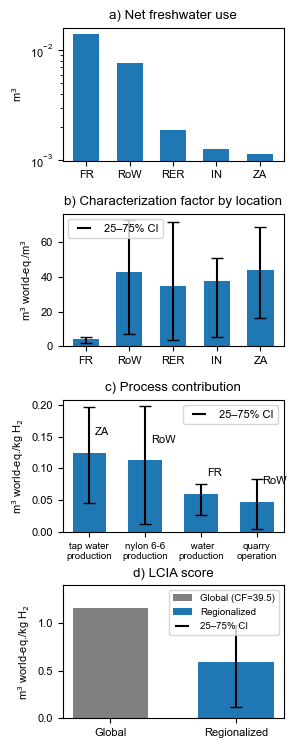

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
cutoff = 0.00

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(3, 8))


plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 8
})

# Legend for CI 25–75
errorbar_legend = Line2D(
    [0], [0],
    color='black',
    linestyle='none',
    marker='_',
    markersize=10,
    markeredgewidth=1.5,
    label='25–75% CI'
)

# remove rows for which "amount" is below the cutoff
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m]

df_net = df.copy()
if "CF (mean)" in df_net.columns:  # Probabilistic case
    df_net.loc[df_net["CF (mean)"] < 0, "amount" ] *= -1
else:
    df_net.loc[df_net["CF"] < 0, "amount"] *= -1


d = df_net.groupby("consumer location").sum(numeric_only=True)
d = d[d["impact (mean)"] > 0] if "impact (mean)" in d.columns else d[d["impact"] > 0]
d = d.sort_values(by="amount", ascending=False).head(5)

d["amount"].plot(kind="bar", ax=axes[0], xlabel='', width=0.6)
axes[0].set_title("a) Net freshwater use")
axes[0].set_ylabel("m$^3$")
axes[0].set_xticks(range(len(d)))
axes[0].set_xticklabels(d.index, rotation=0)
axes[0].set_yscale('log')


# -------- 2. Average CF by location --------
# Add percentile-based error bars if available
# Filter down to the top 10
lower_percentile = "(25th)"
top_percentile = "(75th)"
d_top = df.copy()
d_top = d_top.loc[d_top["CF (mean)"]>0]
d_top = d_top.groupby("consumer location").mean(numeric_only=True)
#d_top = d_top.sort_values(by="amount", ascending=False)
d_top = d_top.loc[d.index]
x = d_top.index
y = d_top["CF (mean)"]

# Ensure CF percentiles exist
if f"CF {lower_percentile}" in d.columns and f"CF {top_percentile}" in d.columns:
    d_top.loc[d_top[f"CF {lower_percentile}"]>d_top["CF (mean)"], f"CF {lower_percentile}"] = d_top["CF (mean)"]
    d_top.loc[d_top[f"CF {top_percentile}"]<d_top["CF (mean)"], f"CF {top_percentile}"] = d_top["CF (mean)"]
    lower = y - d_top[f"CF {lower_percentile}"]
    upper = d_top[f"CF {top_percentile}"] - y
    cf_errors = np.array([lower.values, upper.values])
else:
    cf_errors = None

# Plot with error bars
axes[1].bar(x, y, yerr=cf_errors, capsize=4, width=0.6)
axes[1].set_title("b) Characterization factor by location")
axes[1].set_ylabel("m$^3$ world-eq./m$^3$")
axes[1].set_xticks(range(len(x)))
axes[1].set_xticks(range(len(x)))
axes[1].set_xticklabels(x, rotation=0)

axes[1].legend(handles=[errorbar_legend], loc='upper left', fontsize=8)
#axes[1].legend().remove()

# -------- 3. Grouped bar plot with error bars --------
df_ = df.copy()
df_["consumer name"] = df_["consumer name"].str.split(", ").str[0]
df_["label"] = df_["consumer name"] + " (" + df_["consumer location"] + ")"
df_.loc[df_["CF (mean)"]<0, f"impact {lower_percentile}"] = df.loc[df["CF (mean)"]<0, f"impact {top_percentile}"]
df_.loc[df_["CF (mean)"]<0, f"impact {top_percentile}"] = df.loc[df["CF (mean)"]<0, f"impact {lower_percentile}"]
# Compute mean impact and select top 4
top_df = df_[["label", "impact (mean)", f"impact {lower_percentile}", f"impact {top_percentile}"]].copy()
top_df = top_df.groupby("label", as_index=False).sum(numeric_only=True)
top_df = top_df.sort_values(by="impact (mean)", ascending=False).head(4)

# Compute asymmetric error bars
y = top_df["impact (mean)"]
err_lower = y - top_df[f"impact {lower_percentile}"]
err_upper = top_df[f"impact {top_percentile}"] - y
errors = np.array([err_lower.values, err_upper.values])
errors = np.clip(errors, 0, None)

df_global = df_table.copy()
df_global.loc[df_global["CF (mean)"]<0, "CF (mean)"] = -39.5
df_global.loc[df_global["CF (mean)"]>0, "CF (mean)"] = +39.5
df_global["impact (mean)"] = df_global["amount"] * df_global["CF (mean)"]
total_global = df_global["impact (mean)"].sum()
total_regionalized = df_table.copy()
total_regionalized.loc[total_regionalized["CF (mean)"]<0, f"impact {lower_percentile}"] = df_table.loc[df_table["CF (mean)"]<0, f"impact {top_percentile}"]
total_regionalized.loc[total_regionalized["CF (mean)"]<0, f"impact {top_percentile}"] = df_table.loc[df_table["CF (mean)"]<0, f"impact {lower_percentile}"]


# Plot
x = np.arange(len(top_df))
axes[2].bar(x, y, yerr=errors, capsize=4, width=0.6)
axes[2].set_xticks(x)
axes[2].set_xticklabels(top_df["label"].str.replace(" ", "\n"), rotation=0, ha="center")
axes[2].set_title("c) Process contribution")
axes[2].set_ylabel("m$^3$ world-eq./kg H$_2$")
axes[2].tick_params(axis="x", labelsize=8)
#axes[2].legend().remove()
axes[2].legend(handles=[errorbar_legend], loc='upper right', fontsize=8)

# Set x-axis ticks
axes[2].set_xticks(x)

# Extract country codes from the label (e.g., "Some process (FR)" → "FR")
labels = top_df["label"].str.replace(r" \(([^)]+)\)$", "", regex=True)
countries = top_df["label"].str.extract(r"\(([^)]+)\)$")[0]

# Set shortened labels (without country codes)
labels = [label.rsplit(" ", 1)[0] + "\n" + label.rsplit(" ", 1)[1] if " " in label else label
     for label in labels]
labels = [label.replace("deionized", "").replace("gravel and sand ", "") for label in labels]
axes[2].set_xticklabels(
    labels,
    rotation=0,
    ha="center",
    size=7
)

# Annotate with country codes above bars
for xi, yi, code in zip(x, y, countries):
    axes[2].annotate(
        code,
        (xi + 0.1, yi + 0.03),  # Shift slightly to the right
        textcoords="offset points",
        xytext=(0.1, -1),
        ha='left',
        fontsize=8,
    )

# === Fourth plot (d) - Global vs Regionalized ===
global_mean = total_global
regional_mean = total_regionalized["impact (mean)"].sum()
regional_min = total_regionalized[f"impact {lower_percentile}"].sum()
regional_max = total_regionalized[f"impact {top_percentile}"].sum()

regional_error = [
    regional_mean - regional_min,
    regional_max - regional_mean
]

ax4 = axes[3]
ax4.bar(["Global"], [global_mean], color="gray", label="Global (CF=39.5)", width=.6)

ax4.bar(
    1,
    total_regionalized["impact (mean)"].sum(),
    yerr=[[np.clip(total_regionalized["impact (mean)"].sum() - total_regionalized[f"impact {lower_percentile}"].sum(), 0, None)],
          [np.clip(total_regionalized[f"impact {top_percentile}"].sum() - total_regionalized["impact (mean)"].sum(), 0, None)]],
    capsize=4,
    width=.6,
    color='#1f77b4',
    label='Regionalized'
)

ax4.set_title("d) LCIA score")
ax4.set_ylabel("m$^3$ world-eq./kg H$_2$")
ax4.set_ylim(0, max(global_mean, regional_max) * 1.2)
#ax4.set_ylim(0, 45)
ax4.set_xticks([0, 1])
ax4.set_xticklabels(["Global", "Regionalized"])

# Append to existing legend
handles, labels = axes[3].get_legend_handles_labels()
handles.append(errorbar_legend)
labels.append('25–75% CI')
axes[3].legend(handles=handles, labels=labels, loc='upper right', fontsize=7)

# === Final layout tweaks ===
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.savefig("figure_1.png", bbox_inches="tight", dpi=150)
plt.show()

In [ ]:
(0.000 * (80.5)) + (0.014 * (59.3)) + (0.003 * (2.14)) + (0.002 * (2.79)) + (0.001 * (4.77)) + (0.014 * (59.4)) + (0.001 * (3.68)) + (0.002 * (2.07)) + (0.001 * (3.34)) + (0.028 * (2.92)) + (0.006 * (2.7)) + (0.000 * (2.03)) + (0.000 * (2.28)) + (0.205 * (15.8)) + (0.003 * (14.9)) + (0.000 * (59.6)) + (0.184 * (85.1)) + (0.004 * (2.68)) + (0.009 * (2.38)) + (0.000 * (2.56)) + (0.000 * (1.06)) + (0.001 * (0.663)) + (0.349 * (51.9)) + (0.000 * (2.77)) + (0.000 * (1.5)) + (0.000 * (2.81)) + (0.000 * (1.66)) + (0.000 * (2.23)) + (0.000 * (7.17)) + (0.002 * (3.04)) + (0.002 * (1.47)) + (0.012 * (88.8)) + (0.000 * (10.7)) + (0.008 * (2.17)) + (0.001 * (0.713)) + (0.003 * (3.0)) + (0.049 * (45.8)) + (0.013 * (6.71)) + (0.004 * (5.37)) + (0.002 * (3.7)) + (0.001 * (2.02)) + (0.002 * (2.13)) + (0.000 * (13.2)) + (0.072 * (18.2))

In [ ]:
(0.000 * (-80.5)) + (0.014 * (-59.3)) + (0.003 * (-2.14)) + (0.002 * (-2.79)) + (0.001 * (-4.77)) + (0.014 * (-59.4)) + (0.001 * (-3.68)) + (0.002 * (-2.07)) + (0.001 * (-3.34)) + (0.028 * (-2.92)) + (0.006 * (-2.7)) + (0.000 * (-2.03)) + (0.000 * (-2.28)) + (0.205 * (-15.8)) + (0.003 * (-14.9)) + (0.000 * (-59.6)) + (0.184 * (-85.1)) + (0.004 * (-2.68)) + (0.009 * (-2.38)) + (0.000 * (-2.56)) + (0.000 * (-1.06)) + (0.001 * (-0.663)) + (0.349 * (-51.9)) + (0.000 * (-2.77)) + (0.000 * (-1.5)) + (0.000 * (-2.81)) + (0.000 * (-1.66)) + (0.000 * (-2.23)) + (0.000 * (-7.17)) + (0.002 * (-3.04)) + (0.002 * (-1.47)) + (0.012 * (-88.8)) + (0.000 * (-10.7)) + (0.008 * (-2.17)) + (0.001 * (-0.713)) + (0.003 * (-3.0)) + (0.049 * (-45.8)) + (0.013 * (-6.71)) + (0.004 * (-5.37)) + (0.002 * (-3.7)) + (0.001 * (-2.02)) + (0.002 * (-2.13)) + (0.000 * (-13.2)) + (0.072 * (-18.2))

In [ ]:
(0.000 * (80.5)) + (0.014 * (59.3)) + (0.003 * (2.14)) + (0.002 * (2.79)) + (0.001 * (4.77)) + (0.014 * (59.4)) + (0.001 * (3.68)) + (0.002 * (2.07)) + (0.001 * (3.34)) + (0.028 * (2.92)) + (0.006 * (2.7)) + (0.000 * (2.03)) + (0.000 * (2.28)) + (0.205 * (15.8)) + (0.003 * (14.9)) + (0.000 * (59.6)) + (0.184 * (85.1)) + (0.004 * (2.68)) + (0.009 * (2.38)) + (0.000 * (2.56)) + (0.000 * (1.06)) + (0.001 * (0.663)) + (0.349 * (51.9)) + (0.000 * (2.77)) + (0.000 * (1.5)) + (0.000 * (2.81)) + (0.000 * (1.66)) + (0.000 * (2.23)) + (0.000 * (7.17)) + (0.002 * (3.04)) + (0.002 * (1.47)) + (0.012 * (88.8)) + (0.000 * (10.7)) + (0.008 * (2.17)) + (0.001 * (0.713)) + (0.003 * (3.0)) + (0.049 * (45.8)) + (0.013 * (6.71)) + (0.004 * (5.37)) + (0.002 * (3.7)) + (0.001 * (2.02)) + (0.002 * (2.13)) + (0.000 * (13.2)) + (0.072 * (18.2))

In [ ]:
(0.000 * (80.5)) + (0.014 * (59.3)) + (0.003 * (2.14)) + (0.002 * (2.79)) + (0.001 * (4.77)) + (0.014 * (59.4)) + (0.001 * (3.68)) + (0.002 * (2.07)) + (0.001 * (3.34)) + (0.028 * (2.92)) + (0.006 * (2.7)) + (0.000 * (2.03)) + (0.000 * (2.28)) + (0.205 * (15.8)) + (0.003 * (14.9)) + (0.000 * (59.6)) + (0.184 * (85.1)) + (0.004 * (2.68)) + (0.009 * (2.38)) + (0.000 * (2.56)) + (0.000 * (1.06)) + (0.001 * (0.663)) + (0.349 * (51.9)) + (0.000 * (2.77)) + (0.000 * (1.5)) + (0.000 * (2.81)) + (0.000 * (1.66)) + (0.000 * (2.23)) + (0.000 * (7.17)) + (0.002 * (3.04)) + (0.002 * (1.47)) + (0.012 * (88.8)) + (0.000 * (10.7)) + (0.008 * (2.17)) + (0.001 * (0.713)) + (0.003 * (3.0)) + (0.049 * (45.8)) + (0.013 * (6.71)) + (0.004 * (5.37)) + (0.002 * (3.7)) + (0.001 * (2.02)) + (0.002 * (2.13)) + (0.000 * (13.2)) + (0.072 * (18.2))

In [ ]:
(0.000 * (80.5)) + (0.014 * (59.3)) + (0.003 * (2.14)) + (0.002 * (2.79)) + (0.001 * (4.77)) + (0.014 * (59.4)) + (0.001 * (3.68)) + (0.002 * (2.07)) + (0.001 * (3.34)) + (0.028 * (2.92)) + (0.006 * (2.7)) + (0.000 * (2.03)) + (0.000 * (2.28)) + (0.205 * (15.8)) + (0.003 * (14.9)) + (0.000 * (59.6)) + (0.184 * (85.1)) + (0.004 * (2.68)) + (0.009 * (2.38)) + (0.000 * (2.56)) + (0.000 * (1.06)) + (0.001 * (0.663)) + (0.349 * (51.9)) + (0.000 * (2.77)) + (0.000 * (1.5)) + (0.000 * (2.81)) + (0.000 * (1.66)) + (0.000 * (2.23)) + (0.000 * (7.17)) + (0.002 * (3.04)) + (0.002 * (1.47)) + (0.012 * (88.8)) + (0.000 * (10.7)) + (0.008 * (2.17)) + (0.001 * (0.713)) + (0.003 * (3.0)) + (0.049 * (45.8)) + (0.013 * (6.71)) + (0.004 * (5.37)) + (0.002 * (3.7)) + (0.001 * (2.02)) + (0.002 * (2.13)) + (0.000 * (13.2)) + (0.072 * (18.2))

In [ ]:
(0.000 * (80.5)) + (0.014 * (59.3)) + (0.003 * (2.14)) + (0.002 * (2.79)) + (0.001 * (4.77)) + (0.014 * (59.4)) + (0.001 * (3.68)) + (0.002 * (2.07)) + (0.001 * (3.34)) + (0.028 * (2.92)) + (0.006 * (2.7)) + (0.000 * (2.03)) + (0.000 * (2.28)) + (0.205 * (15.8)) + (0.003 * (14.9)) + (0.000 * (59.6)) + (0.184 * (85.1)) + (0.004 * (2.68)) + (0.009 * (2.38)) + (0.000 * (2.56)) + (0.000 * (1.06)) + (0.001 * (0.663)) + (0.349 * (51.9)) + (0.000 * (2.77)) + (0.000 * (1.5)) + (0.000 * (2.81)) + (0.000 * (1.66)) + (0.000 * (2.23)) + (0.000 * (7.17)) + (0.002 * (3.04)) + (0.002 * (1.47)) + (0.012 * (88.8)) + (0.000 * (10.7)) + (0.008 * (2.17)) + (0.001 * (0.713)) + (0.003 * (3.0)) + (0.049 * (45.8)) + (0.013 * (6.71)) + (0.004 * (5.37)) + (0.002 * (3.7)) + (0.001 * (2.02)) + (0.002 * (2.13)) + (0.000 * (13.2)) + (0.072 * (18.2))

In [ ]:
(0.000 * (-80.5)) + (0.000 * (-17.4)) + (0.013 * (-59.6)) + (0.000 * (-9.44)) + (0.000 * (-59.3)) + (0.001 * (-88.6)) + (0.000 * (-10.4)) + (0.007 * (-41.5)) + (0.000 * (-1.26)) + (0.000 * (-2.14)) + (0.005 * (-95.0)) + (0.002 * (-51.1)) + (0.001 * (-80.9)) + (0.000 * (-5.74)) + (0.002 * (-89.0)) + (0.000 * (-35.8)) + (0.000 * (-58.4)) + (0.005 * (-86.1)) + (0.000 * (-2.79)) + (0.000 * (-60.5)) + (0.021 * (-8.42)) + (0.000 * (-4.77)) + (0.000 * (-28.7)) + (0.000 * (-59.4)) + (0.000 * (-3.52)) + (0.000 * (-43.0)) + (0.000 * (-7.48)) + (0.000 * (-0.266)) + (0.000 * (-7.32)) + (0.000 * (-0.672)) + (0.000 * (-9.2)) + (0.000 * (-0.209)) + (0.000 * (-0.408)) + (0.002 * (-6.9)) + (0.001 * (-19.3)) + (0.000 * (-1.83)) + (0.001 * (-2.63)) + (0.001 * (-1.57)) + (0.000 * (-10.3)) + (0.001 * (-2.8)) + (0.000 * (-1.34)) + (0.000 * (-2.21)) + (0.000 * (-2.0)) + (0.000 * (-21.1)) + (0.001 * (-15.3)) + (0.000 * (-15.7)) + (0.000 * (-0.984)) + (0.000 * (-1.96)) + (0.000 * (-16.5)) + (0.000 * (-0.558)) + (0.000 * (-1.61)) + (0.001 * (-0.873)) + (0.000 * (-0.612)) + (0.000 * (-6.27)) + (0.002 * (-0.971)) + (0.000 * (-3.07)) + (0.000 * (-19.3)) + (0.000 * (-4.52)) + (0.000 * (-16.3)) + (0.000 * (-3.68)) + (0.000 * (-1.78)) + (0.002 * (-10.9)) + (0.000 * (-1.95)) + (0.000 * (-4.34)) + (0.000 * (-1.05)) + (0.000 * (-0.796)) + (0.000 * (-2.02)) + (0.000 * (-0.62)) + (0.000 * (-10.3)) + (0.000 * (-1.11)) + (0.000 * (-3.16)) + (0.000 * (-1.09)) + (0.000 * (-13.2)) + (0.000 * (-1.26)) + (0.000 * (-36.7)) + (0.000 * (-6.88)) + (0.000 * (-0.765)) + (0.000 * (-2.07)) + (0.000 * (-6.32)) + (0.006 * (-91.3)) + (0.000 * (-7.07)) + (0.010 * (-0.271)) + (0.001 * (-2.44)) + (0.001 * (-0.736)) + (0.005 * (-2.35)) + (0.009 * (-3.09)) + (0.006 * (-51.5)) + (0.004 * (-1.18)) + (0.002 * (-0.735)) + (0.001 * (-32.1)) + (0.015 * (-12.8)) + (0.014 * (-6.99)) + (0.004 * (-2.68)) + (0.008 * (-0.529)) + (0.009 * (-0.335)) + (0.006 * (-17.9)) + (0.012 * (-0.958)) + (0.008 * (-0.284)) + (0.006 * (-55.6)) + (0.013 * (-52.1)) + (0.003 * (-31.5)) + (0.002 * (-29.8)) + (0.004 * (-27.2)) + (0.005 * (-1.01)) + (0.016 * (-16.6)) + (0.001 * (-0.243)) + (0.005 * (-21.3)) + (0.001 * (-4.13)) + (0.039 * (-84.0)) + (0.006 * (-2.03)) + (0.005 * (-0.591)) + (0.001 * (-3.96)) + (0.000 * (-2.62)) + (0.000 * (-4.61)) + (0.000 * (-77.9)) + (0.000 * (-95.7)) + (0.000 * (-3.34)) + (0.001 * (-2.92)) + (0.000 * (-14.3)) + (0.000 * (-2.7)) + (0.000 * (-41.3)) + (0.001 * (-18.6)) + (0.004 * (-78.5)) + (0.002 * (-8.66)) + (0.000 * (-2.03)) + (0.044 * (-88.6)) + (0.000 * (-36.5)) + (0.000 * (-48.9)) + (0.001 * (-38.2)) + (0.000 * (-2.28)) + (0.000 * (-2.16)) + (0.000 * (-2.92)) + (0.000 * (-0.519)) + (0.005 * (-15.8)) + (0.000 * (-1.01)) + (0.000 * (-14.9)) + (0.000 * (-86.3)) + (0.000 * (-86.2)) + (0.000 * (-0.572)) + (0.000 * (-21.4)) + (0.000 * (-59.6)) + (0.000 * (-5.59)) + (0.000 * (-10.9)) + (0.000 * (-26.1)) + (0.000 * (-0.591)) + (0.004 * (-85.1)) + (0.000 * (-0.79)) + (0.000 * (-3.33)) + (0.000 * (-1.22)) + (0.000 * (-1.76)) + (0.000 * (-2.68)) + (0.000 * (-4.29)) + (0.000 * (-2.38)) + (0.017 * (-25.1)) + (0.000 * (-2.56)) + (0.001 * (-93.8)) + (0.000 * (-1.06)) + (0.015 * (-47.0)) + (0.000 * (-1.89)) + (0.001 * (-4.95)) + (0.012 * (-47.9)) + (0.000 * (-16.1)) + (0.003 * (-10.1)) + (0.000 * (-53.7)) + (0.000 * (-8.83)) + (0.000 * (-22.8)) + (0.016 * (-42.9)) + (0.000 * (-22.0)) + (0.009 * (-12.6)) + (0.002 * (-38.6)) + (0.001 * (-13.0)) + (0.024 * (-50.8)) + (0.003 * (-54.7)) + (0.023 * (-19.6)) + (0.000 * (-3.57)) + (0.000 * (-2.2)) + (0.021 * (-43.4)) + (0.000 * (-1.46)) + (0.000 * (-4.36)) + (0.006 * (-26.0)) + (0.008 * (-35.5)) + (0.000 * (-46.1)) + (0.017 * (-23.0)) + (0.000 * (-0.331)) + (0.020 * (-75.6)) + (0.000 * (-1.89)) + (0.027 * (-17.1)) + (0.001 * (-7.79)) + (0.009 * (-19.7)) + (0.019 * (-73.7)) + (0.048 * (-70.9)) + (0.000 * (-0.663)) + (0.008 * (-51.9)) + (0.000 * (-2.77)) + (0.000 * (-48.1)) + (0.001 * (-88.5)) + (0.004 * (-0.864)) + (0.000 * (-16.6)) + (0.004 * (-83.5)) + (0.001 * (-7.39)) + (0.000 * (-1.12)) + (0.000 * (-64.5)) + (0.002 * (-3.78)) + (0.001 * (-0.973)) + (0.000 * (-44.0)) + (0.013 * (-63.8)) + (0.001 * (-3.88)) + (0.001 * (-96.9)) + (0.000 * (-61.2)) + (0.000 * (-1.5)) + (0.003 * (-38.5)) + (0.000 * (-1.27)) + (0.000 * (-43.9)) + (0.000 * (-2.81)) + (0.000 * (-1.66)) + (0.000 * (-2.23)) + (0.002 * (-62.2)) + (0.011 * (-92.8)) + (0.000 * (-7.17)) + (0.000 * (-3.04)) + (0.000 * (-1.47)) + (0.002 * (-13.4)) + (0.000 * (-88.8)) + (0.001 * (-15.8)) + (0.011 * (-3.19)) + (0.000 * (-22.5)) + (0.000 * (-38.5)) + (0.000 * (-63.5)) + (0.000 * (-49.7)) + (0.000 * (-10.7)) + (0.000 * (-33.5)) + (0.000 * (-5.36)) + (0.017 * (-41.8)) + (0.001 * (-0.878)) + (0.000 * (-5.21)) + (0.000 * (-39.6)) + (0.000 * (-5.25)) + (0.000 * (-8.96)) + (0.001 * (-9.77)) + (0.000 * (-1.51)) + (0.000 * (-2.17)) + (0.000 * (-0.713)) + (0.003 * (-39.0)) + (0.001 * (-11.2)) + (0.000 * (-26.3)) + (0.000 * (-1.35)) + (0.007 * (-37.6)) + (0.000 * (-0.394)) + (0.006 * (-11.0)) + (0.059 * (-47.1)) + (0.000 * (-3.0)) + (0.000 * (-0.792)) + (0.000 * (-6.53)) + (0.001 * (-45.8)) + (0.000 * (-2.04)) + (0.000 * (-31.1)) + (0.000 * (-0.284)) + (0.000 * (-6.71)) + (0.000 * (-5.37)) + (0.000 * (-52.7)) + (0.006 * (-38.1)) + (0.000 * (-0.413)) + (0.004 * (-54.1)) + (0.000 * (-3.7)) + (0.000 * (-0.867)) + (0.000 * (-2.02)) + (0.000 * (-2.13)) + (0.000 * (-4.07)) + (0.000 * (-13.2)) + (0.000 * (-52.4)) + (0.000 * (-73.4)) + (0.000 * (-1.37)) + (0.000 * (-82.3)) + (0.000 * (-1.87)) + (0.008 * (-96.6)) + (0.000 * (-2.72)) + (0.000 * (-34.3)) + (0.000 * (-10.2)) + (0.000 * (-14.2)) + (0.013 * (-10.9)) + (0.003 * (-84.3)) + (0.000 * (-7.46)) + (0.011 * (-74.5)) + (0.003 * (-78.8)) + (0.000 * (-1.55)) + (0.018 * (-70.7)) + (0.000 * (-3.02)) + (0.001 * (-10.4)) + (0.001 * (-17.0)) + (0.002 * (-18.2)) + (0.000 * (-80.2)) + (0.019 * (-76.6)) + (0.005 * (-55.7)) + (0.001 * (-5.12)) + (0.000 * (-8.36)) + (0.007 * (-6.52)) + (0.000 * (-1.66)) + (0.000 * (-1.48)) + (0.000 * (-2.45)) + (0.000 * (-12.0)) + (0.006 * (-33.8)) + (0.000 * (-1.4)) + (0.004 * (-21.8)) + (0.000 * (-16.4)) + (0.004 * (-2.96)) + (0.000 * (-1.69)) + (0.001 * (-0.81)) + (0.019 * (-83.8)) + (0.000 * (-36.2)) + (0.002 * (-16.0)) + (0.000 * (-22.8)) + (0.014 * (-14.0)) + (0.000 * (-1.11)) + (0.000 * (-1.06)) + (0.003 * (-67.2)) + (0.007 * (-68.5)) + (0.000 * (-4.74)) + (0.001 * (-4.54))

In [ ]:
(0.000 * (80.5)) + (0.000 * (17.4)) + (0.013 * (59.6)) + (0.000 * (9.44)) + (0.000 * (59.3)) + (0.001 * (88.6)) + (0.000 * (10.4)) + (0.007 * (41.5)) + (0.000 * (1.26)) + (0.000 * (2.14)) + (0.005 * (95.0)) + (0.002 * (51.1)) + (0.001 * (80.9)) + (0.000 * (5.74)) + (0.002 * (89.0)) + (0.000 * (35.8)) + (0.000 * (58.4)) + (0.005 * (86.1)) + (0.000 * (2.79)) + (0.000 * (60.5)) + (0.021 * (8.42)) + (0.000 * (4.77)) + (0.000 * (28.7)) + (0.000 * (59.4)) + (0.000 * (3.52)) + (0.000 * (43.0)) + (0.000 * (7.48)) + (0.000 * (0.266)) + (0.000 * (7.32)) + (0.000 * (0.672)) + (0.000 * (9.2)) + (0.000 * (0.209)) + (0.000 * (0.408)) + (0.002 * (6.9)) + (0.001 * (19.3)) + (0.000 * (1.83)) + (0.001 * (2.63)) + (0.001 * (1.57)) + (0.000 * (10.3)) + (0.001 * (2.8)) + (0.000 * (1.34)) + (0.000 * (2.21)) + (0.000 * (2.0)) + (0.000 * (21.1)) + (0.001 * (15.3)) + (0.000 * (15.7)) + (0.000 * (0.984)) + (0.000 * (1.96)) + (0.000 * (16.5)) + (0.000 * (0.558)) + (0.000 * (1.61)) + (0.001 * (0.873)) + (0.000 * (0.612)) + (0.000 * (6.27)) + (0.002 * (0.971)) + (0.000 * (3.07)) + (0.000 * (19.3)) + (0.000 * (4.52)) + (0.000 * (16.3)) + (0.000 * (3.68)) + (0.000 * (1.78)) + (0.002 * (10.9)) + (0.000 * (1.95)) + (0.000 * (4.34)) + (0.000 * (1.05)) + (0.000 * (0.796)) + (0.000 * (2.02)) + (0.000 * (0.62)) + (0.000 * (10.3)) + (0.000 * (1.11)) + (0.000 * (3.16)) + (0.000 * (1.09)) + (0.000 * (13.2)) + (0.000 * (1.26)) + (0.000 * (36.7)) + (0.000 * (6.88)) + (0.000 * (0.765)) + (0.000 * (2.07)) + (0.000 * (6.32)) + (0.006 * (91.3)) + (0.000 * (7.07)) + (0.010 * (0.271)) + (0.001 * (2.44)) + (0.001 * (0.736)) + (0.005 * (2.35)) + (0.009 * (3.09)) + (0.006 * (51.5)) + (0.004 * (1.18)) + (0.002 * (0.735)) + (0.001 * (32.1)) + (0.015 * (12.8)) + (0.014 * (6.99)) + (0.004 * (2.68)) + (0.008 * (0.529)) + (0.009 * (0.335)) + (0.006 * (17.9)) + (0.012 * (0.958)) + (0.008 * (0.284)) + (0.006 * (55.6)) + (0.013 * (52.1)) + (0.003 * (31.5)) + (0.002 * (29.8)) + (0.004 * (27.2)) + (0.005 * (1.01)) + (0.016 * (16.6)) + (0.001 * (0.243)) + (0.005 * (21.3)) + (0.001 * (4.13)) + (0.039 * (84.0)) + (0.006 * (2.03)) + (0.005 * (0.591)) + (0.001 * (3.96)) + (0.000 * (2.62)) + (0.000 * (4.61)) + (0.000 * (77.9)) + (0.000 * (95.7)) + (0.000 * (3.34)) + (0.001 * (2.92)) + (0.000 * (14.3)) + (0.000 * (2.7)) + (0.000 * (41.3)) + (0.001 * (18.6)) + (0.004 * (78.5)) + (0.002 * (8.66)) + (0.000 * (2.03)) + (0.044 * (88.6)) + (0.000 * (36.5)) + (0.000 * (48.9)) + (0.001 * (38.2)) + (0.000 * (2.28)) + (0.000 * (2.16)) + (0.000 * (2.92)) + (0.000 * (0.519)) + (0.005 * (15.8)) + (0.000 * (1.01)) + (0.000 * (14.9)) + (0.000 * (86.3)) + (0.000 * (86.2)) + (0.000 * (0.572)) + (0.000 * (21.4)) + (0.000 * (59.6)) + (0.000 * (5.59)) + (0.000 * (10.9)) + (0.000 * (26.1)) + (0.000 * (0.591)) + (0.004 * (85.1)) + (0.000 * (0.79)) + (0.000 * (3.33)) + (0.000 * (1.22)) + (0.000 * (1.76)) + (0.000 * (2.68)) + (0.000 * (4.29)) + (0.000 * (2.38)) + (0.017 * (25.1)) + (0.000 * (2.56)) + (0.001 * (93.8)) + (0.000 * (1.06)) + (0.015 * (47.0)) + (0.000 * (1.89)) + (0.001 * (4.95)) + (0.012 * (47.9)) + (0.000 * (16.1)) + (0.003 * (10.1)) + (0.000 * (53.7)) + (0.000 * (8.83)) + (0.000 * (22.8)) + (0.016 * (42.9)) + (0.000 * (22.0)) + (0.009 * (12.6)) + (0.002 * (38.6)) + (0.001 * (13.0)) + (0.024 * (50.8)) + (0.003 * (54.7)) + (0.023 * (19.6)) + (0.000 * (3.57)) + (0.000 * (2.2)) + (0.021 * (43.4)) + (0.000 * (1.46)) + (0.000 * (4.36)) + (0.006 * (26.0)) + (0.008 * (35.5)) + (0.000 * (46.1)) + (0.017 * (23.0)) + (0.000 * (0.331)) + (0.020 * (75.6)) + (0.000 * (1.89)) + (0.027 * (17.1)) + (0.001 * (7.79)) + (0.009 * (19.7)) + (0.019 * (73.7)) + (0.048 * (70.9)) + (0.000 * (0.663)) + (0.008 * (51.9)) + (0.000 * (2.77)) + (0.000 * (48.1)) + (0.001 * (88.5)) + (0.004 * (0.864)) + (0.000 * (16.6)) + (0.004 * (83.5)) + (0.001 * (7.39)) + (0.000 * (1.12)) + (0.000 * (64.5)) + (0.002 * (3.78)) + (0.001 * (0.973)) + (0.000 * (44.0)) + (0.013 * (63.8)) + (0.001 * (3.88)) + (0.001 * (96.9)) + (0.000 * (61.2)) + (0.000 * (1.5)) + (0.003 * (38.5)) + (0.000 * (1.27)) + (0.000 * (43.9)) + (0.000 * (2.81)) + (0.000 * (1.66)) + (0.000 * (2.23)) + (0.002 * (62.2)) + (0.011 * (92.8)) + (0.000 * (7.17)) + (0.000 * (3.04)) + (0.000 * (1.47)) + (0.002 * (13.4)) + (0.000 * (88.8)) + (0.001 * (15.8)) + (0.011 * (3.19)) + (0.000 * (22.5)) + (0.000 * (38.5)) + (0.000 * (63.5)) + (0.000 * (49.7)) + (0.000 * (10.7)) + (0.000 * (33.5)) + (0.000 * (5.36)) + (0.017 * (41.8)) + (0.001 * (0.878)) + (0.000 * (5.21)) + (0.000 * (39.6)) + (0.000 * (5.25)) + (0.000 * (8.96)) + (0.001 * (9.77)) + (0.000 * (1.51)) + (0.000 * (2.17)) + (0.000 * (0.713)) + (0.003 * (39.0)) + (0.001 * (11.2)) + (0.000 * (26.3)) + (0.000 * (1.35)) + (0.007 * (37.6)) + (0.000 * (0.394)) + (0.006 * (11.0)) + (0.059 * (47.1)) + (0.000 * (3.0)) + (0.000 * (0.792)) + (0.000 * (6.53)) + (0.001 * (45.8)) + (0.000 * (2.04)) + (0.000 * (31.1)) + (0.000 * (0.284)) + (0.000 * (6.71)) + (0.000 * (5.37)) + (0.000 * (52.7)) + (0.006 * (38.1)) + (0.000 * (0.413)) + (0.004 * (54.1)) + (0.000 * (3.7)) + (0.000 * (0.867)) + (0.000 * (2.02)) + (0.000 * (2.13)) + (0.000 * (4.07)) + (0.000 * (13.2)) + (0.000 * (52.4)) + (0.000 * (73.4)) + (0.000 * (1.37)) + (0.000 * (82.3)) + (0.000 * (1.87)) + (0.008 * (96.6)) + (0.000 * (2.72)) + (0.000 * (34.3)) + (0.000 * (10.2)) + (0.000 * (14.2)) + (0.013 * (10.9)) + (0.003 * (84.3)) + (0.000 * (7.46)) + (0.011 * (74.5)) + (0.003 * (78.8)) + (0.000 * (1.55)) + (0.018 * (70.7)) + (0.000 * (3.02)) + (0.001 * (10.4)) + (0.001 * (17.0)) + (0.002 * (18.2)) + (0.000 * (80.2)) + (0.019 * (76.6)) + (0.005 * (55.7)) + (0.001 * (5.12)) + (0.000 * (8.36)) + (0.007 * (6.52)) + (0.000 * (1.66)) + (0.000 * (1.48)) + (0.000 * (2.45)) + (0.000 * (12.0)) + (0.006 * (33.8)) + (0.000 * (1.4)) + (0.004 * (21.8)) + (0.000 * (16.4)) + (0.004 * (2.96)) + (0.000 * (1.69)) + (0.001 * (0.81)) + (0.019 * (83.8)) + (0.000 * (36.2)) + (0.002 * (16.0)) + (0.000 * (22.8)) + (0.014 * (14.0)) + (0.000 * (1.11)) + (0.000 * (1.06)) + (0.003 * (67.2)) + (0.007 * (68.5)) + (0.000 * (4.74)) + (0.001 * (4.54))

In [ ]:
(0.001 * (80.5)) + (0.001 * (17.4)) + (0.011 * (59.6)) + (0.001 * (9.44)) + (0.001 * (59.3)) + (0.001 * (88.6)) + (0.001 * (10.4)) + (0.006 * (41.5)) + (0.001 * (1.26)) + (0.001 * (2.14)) + (0.004 * (95.0)) + (0.002 * (51.1)) + (0.001 * (80.9)) + (0.001 * (5.74)) + (0.002 * (89.0)) + (0.001 * (35.8)) + (0.001 * (58.4)) + (0.004 * (86.1)) + (0.001 * (2.79)) + (0.001 * (60.5)) + (0.018 * (8.42)) + (0.001 * (4.77)) + (0.001 * (28.7)) + (0.001 * (59.4)) + (0.001 * (3.52)) + (0.001 * (43.0)) + (0.001 * (7.48)) + (0.001 * (0.266)) + (0.001 * (7.32)) + (0.001 * (0.672)) + (0.001 * (9.2)) + (0.001 * (0.209)) + (0.001 * (0.408)) + (0.001 * (6.9)) + (0.001 * (19.3)) + (0.001 * (1.83)) + (0.001 * (2.63)) + (0.001 * (1.57)) + (0.001 * (10.3)) + (0.001 * (2.8)) + (0.001 * (1.34)) + (0.001 * (2.21)) + (0.001 * (2.0)) + (0.001 * (21.1)) + (0.001 * (15.3)) + (0.001 * (15.7)) + (0.001 * (0.984)) + (0.001 * (1.96)) + (0.001 * (16.5)) + (0.001 * (0.558)) + (0.001 * (1.61)) + (0.001 * (0.873)) + (0.001 * (0.612)) + (0.001 * (6.27)) + (0.001 * (0.971)) + (0.001 * (3.07)) + (0.001 * (19.3)) + (0.001 * (4.52)) + (0.001 * (16.3)) + (0.001 * (3.68)) + (0.001 * (1.78)) + (0.002 * (10.9)) + (0.001 * (1.95)) + (0.001 * (4.34)) + (0.001 * (1.05)) + (0.001 * (0.796)) + (0.001 * (2.02)) + (0.001 * (0.62)) + (0.001 * (10.3)) + (0.001 * (1.11)) + (0.001 * (3.16)) + (0.001 * (1.09)) + (0.001 * (13.2)) + (0.001 * (1.26)) + (0.001 * (36.7)) + (0.001 * (6.88)) + (0.001 * (0.765)) + (0.001 * (2.07)) + (0.001 * (6.32)) + (0.005 * (91.3)) + (0.001 * (7.07)) + (0.009 * (0.271)) + (0.001 * (2.44)) + (0.001 * (0.736)) + (0.004 * (2.35)) + (0.008 * (3.09)) + (0.005 * (51.5)) + (0.003 * (1.18)) + (0.002 * (0.735)) + (0.001 * (32.1)) + (0.013 * (12.8)) + (0.012 * (6.99)) + (0.003 * (2.68)) + (0.007 * (0.529)) + (0.008 * (0.335)) + (0.005 * (17.9)) + (0.011 * (0.958)) + (0.007 * (0.284)) + (0.005 * (55.6)) + (0.011 * (52.1)) + (0.002 * (31.5)) + (0.002 * (29.8)) + (0.003 * (27.2)) + (0.005 * (1.01)) + (0.014 * (16.6)) + (0.001 * (0.243)) + (0.004 * (21.3)) + (0.001 * (4.13)) + (0.034 * (84.0)) + (0.005 * (2.03)) + (0.004 * (0.591)) + (0.001 * (3.96)) + (0.001 * (2.62)) + (0.001 * (4.61)) + (0.001 * (77.9)) + (0.001 * (95.7)) + (0.001 * (3.34)) + (0.001 * (2.92)) + (0.001 * (14.3)) + (0.001 * (2.7)) + (0.001 * (41.3)) + (0.001 * (18.6)) + (0.003 * (78.5)) + (0.001 * (8.66)) + (0.001 * (2.03)) + (0.037 * (88.6)) + (0.001 * (36.5)) + (0.001 * (48.9)) + (0.001 * (38.2)) + (0.001 * (2.28)) + (0.001 * (2.16)) + (0.001 * (2.92)) + (0.001 * (0.519)) + (0.004 * (15.8)) + (0.001 * (1.01)) + (0.001 * (14.9)) + (0.001 * (86.3)) + (0.001 * (86.2)) + (0.001 * (0.572)) + (0.001 * (21.4)) + (0.001 * (59.6)) + (0.001 * (5.59)) + (0.001 * (10.9)) + (0.001 * (26.1)) + (0.001 * (0.591)) + (0.004 * (85.1)) + (0.001 * (0.79)) + (0.001 * (3.33)) + (0.001 * (1.22)) + (0.001 * (1.76)) + (0.001 * (2.68)) + (0.001 * (4.29)) + (0.001 * (2.38)) + (0.015 * (25.1)) + (0.001 * (2.56)) + (0.001 * (93.8)) + (0.001 * (1.06)) + (0.013 * (47.0)) + (0.001 * (1.89)) + (0.001 * (4.95)) + (0.010 * (47.9)) + (0.001 * (16.1)) + (0.002 * (10.1)) + (0.001 * (53.7)) + (0.001 * (8.83)) + (0.001 * (22.8)) + (0.013 * (42.9)) + (0.001 * (22.0)) + (0.008 * (12.6)) + (0.002 * (38.6)) + (0.001 * (13.0)) + (0.021 * (50.8)) + (0.002 * (54.7)) + (0.020 * (19.6)) + (0.001 * (3.57)) + (0.001 * (2.2)) + (0.018 * (43.4)) + (0.001 * (1.46)) + (0.001 * (4.36)) + (0.006 * (26.0)) + (0.007 * (35.5)) + (0.001 * (46.1)) + (0.015 * (23.0)) + (0.001 * (0.331)) + (0.017 * (75.6)) + (0.001 * (1.89)) + (0.023 * (17.1)) + (0.001 * (7.79)) + (0.007 * (19.7)) + (0.016 * (73.7)) + (0.041 * (70.9)) + (0.001 * (0.663)) + (0.007 * (51.9)) + (0.001 * (2.77)) + (0.001 * (48.1)) + (0.001 * (88.5)) + (0.003 * (0.864)) + (0.001 * (16.6)) + (0.003 * (83.5)) + (0.001 * (7.39)) + (0.001 * (1.12)) + (0.001 * (64.5)) + (0.002 * (3.78)) + (0.001 * (0.973)) + (0.001 * (44.0)) + (0.011 * (63.8)) + (0.001 * (3.88)) + (0.001 * (96.9)) + (0.001 * (61.2)) + (0.001 * (1.5)) + (0.002 * (38.5)) + (0.001 * (1.27)) + (0.001 * (43.9)) + (0.001 * (2.81)) + (0.001 * (1.66)) + (0.001 * (2.23)) + (0.002 * (62.2)) + (0.009 * (92.8)) + (0.001 * (7.17)) + (0.001 * (3.04)) + (0.001 * (1.47)) + (0.002 * (13.4)) + (0.001 * (88.8)) + (0.001 * (15.8)) + (0.009 * (3.19)) + (0.001 * (22.5)) + (0.001 * (38.5)) + (0.001 * (63.5)) + (0.001 * (49.7)) + (0.001 * (10.7)) + (0.001 * (33.5)) + (0.001 * (5.36)) + (0.015 * (41.8)) + (0.001 * (0.878)) + (0.001 * (5.21)) + (0.001 * (39.6)) + (0.001 * (5.25)) + (0.001 * (8.96)) + (0.001 * (9.77)) + (0.001 * (1.51)) + (0.001 * (2.17)) + (0.001 * (0.713)) + (0.003 * (39.0)) + (0.001 * (11.2)) + (0.001 * (26.3)) + (0.001 * (1.35)) + (0.006 * (37.6)) + (0.001 * (0.394)) + (0.005 * (11.0)) + (0.050 * (47.1)) + (0.001 * (3.0)) + (0.001 * (0.792)) + (0.001 * (6.53)) + (0.001 * (45.8)) + (0.001 * (2.04)) + (0.001 * (31.1)) + (0.001 * (0.284)) + (0.001 * (6.71)) + (0.001 * (5.37)) + (0.001 * (52.7)) + (0.005 * (38.1)) + (0.001 * (0.413)) + (0.003 * (54.1)) + (0.001 * (3.7)) + (0.001 * (0.867)) + (0.001 * (2.02)) + (0.001 * (2.13)) + (0.001 * (4.07)) + (0.001 * (13.2)) + (0.001 * (52.4)) + (0.001 * (73.4)) + (0.001 * (1.37)) + (0.001 * (82.3)) + (0.001 * (1.87)) + (0.007 * (96.6)) + (0.001 * (2.72)) + (0.001 * (34.3)) + (0.001 * (10.2)) + (0.001 * (14.2)) + (0.011 * (10.9)) + (0.003 * (84.3)) + (0.001 * (7.46)) + (0.009 * (74.5)) + (0.002 * (78.8)) + (0.001 * (1.55)) + (0.016 * (70.7)) + (0.001 * (3.02)) + (0.001 * (10.4)) + (0.001 * (17.0)) + (0.001 * (18.2)) + (0.001 * (80.2)) + (0.016 * (76.6)) + (0.004 * (55.7)) + (0.001 * (5.12)) + (0.001 * (8.36)) + (0.006 * (6.52)) + (0.001 * (1.66)) + (0.001 * (1.48)) + (0.001 * (2.45)) + (0.001 * (12.0)) + (0.005 * (33.8)) + (0.001 * (1.4)) + (0.003 * (21.8)) + (0.001 * (16.4)) + (0.003 * (2.96)) + (0.001 * (1.69)) + (0.001 * (0.81)) + (0.017 * (83.8)) + (0.001 * (36.2)) + (0.001 * (16.0)) + (0.001 * (22.8)) + (0.012 * (14.0)) + (0.001 * (1.11)) + (0.001 * (1.06)) + (0.002 * (67.2)) + (0.006 * (68.5)) + (0.001 * (4.74)) + (0.001 * (4.54))

In [ ]:
(0.013 * (-59.6)) + (0.007 * (-41.5)) + (0.005 * (-95.0)) + (0.002 * (-51.1)) + (0.002 * (-89.0)) + (0.005 * (-86.1)) + (0.021 * (-8.42)) + (0.002 * (-6.9)) + (0.001 * (-2.8)) + (0.001 * (-0.873)) + (0.002 * (-0.971)) + (0.002 * (-10.9)) + (0.007 * (-91.3)) + (0.011 * (-0.271)) + (0.002 * (-0.736)) + (0.005 * (-2.35)) + (0.010 * (-3.09)) + (0.006 * (-51.5)) + (0.004 * (-1.18)) + (0.002 * (-0.735)) + (0.002 * (-32.1)) + (0.015 * (-12.8)) + (0.015 * (-6.99)) + (0.004 * (-2.68)) + (0.009 * (-0.529)) + (0.009 * (-0.335)) + (0.006 * (-17.9)) + (0.013 * (-0.958)) + (0.008 * (-0.284)) + (0.006 * (-55.6)) + (0.013 * (-52.1)) + (0.003 * (-31.5)) + (0.002 * (-29.8)) + (0.004 * (-27.2)) + (0.006 * (-1.01)) + (0.017 * (-16.6)) + (0.001 * (-0.243)) + (0.005 * (-21.3)) + (0.001 * (-4.13)) + (0.041 * (-84.0)) + (0.006 * (-2.03)) + (0.005 * (-0.591)) + (0.001 * (-3.96)) + (0.001 * (-18.6)) + (0.004 * (-78.5)) + (0.002 * (-8.66)) + (0.046 * (-88.6)) + (0.001 * (-38.2)) + (0.005 * (-15.8)) + (0.004 * (-85.1)) + (0.018 * (-25.1)) + (0.016 * (-47.0)) + (0.001 * (-4.95)) + (0.012 * (-47.9)) + (0.003 * (-10.1)) + (0.016 * (-42.9)) + (0.009 * (-12.6)) + (0.002 * (-38.6)) + (0.025 * (-50.8)) + (0.003 * (-54.7)) + (0.024 * (-19.6)) + (0.021 * (-43.4)) + (0.007 * (-26.0)) + (0.009 * (-35.5)) + (0.018 * (-23.0)) + (0.020 * (-75.6)) + (0.028 * (-17.1)) + (0.009 * (-19.7)) + (0.019 * (-73.7)) + (0.050 * (-70.9)) + (0.008 * (-51.9)) + (0.004 * (-0.864)) + (0.004 * (-83.5)) + (0.001 * (-7.39)) + (0.002 * (-3.78)) + (0.001 * (-0.973)) + (0.013 * (-63.8)) + (0.003 * (-38.5)) + (0.002 * (-62.2)) + (0.011 * (-92.8)) + (0.003 * (-13.4)) + (0.001 * (-15.8)) + (0.011 * (-3.19)) + (0.018 * (-41.8)) + (0.003 * (-39.0)) + (0.001 * (-11.2)) + (0.007 * (-37.6)) + (0.007 * (-11.0)) + (0.061 * (-47.1)) + (0.001 * (-45.8)) + (0.006 * (-38.1)) + (0.004 * (-54.1)) + (0.008 * (-96.6)) + (0.014 * (-10.9)) + (0.003 * (-84.3)) + (0.011 * (-74.5)) + (0.003 * (-78.8)) + (0.019 * (-70.7)) + (0.001 * (-10.4)) + (0.002 * (-18.2)) + (0.019 * (-76.6)) + (0.005 * (-55.7)) + (0.007 * (-6.52)) + (0.006 * (-33.8)) + (0.004 * (-21.8)) + (0.004 * (-2.96)) + (0.020 * (-83.8)) + (0.002 * (-16.0)) + (0.014 * (-14.0)) + (0.003 * (-67.2)) + (0.007 * (-68.5))

In [ ]:
(0.000 * (-80.5)) + (0.000 * (-17.4)) + (0.013 * (-59.6)) + (0.000 * (-9.44)) + (0.000 * (-59.3)) + (0.001 * (-88.6)) + (0.000 * (-10.4)) + (0.007 * (-41.5)) + (0.000 * (-1.26)) + (0.000 * (-2.14)) + (0.005 * (-95.0)) + (0.002 * (-51.1)) + (0.001 * (-80.9)) + (0.000 * (-5.74)) + (0.002 * (-89.0)) + (0.000 * (-35.8)) + (0.000 * (-58.4)) + (0.005 * (-86.1)) + (0.000 * (-2.79)) + (0.000 * (-60.5)) + (0.021 * (-8.42)) + (0.000 * (-4.77)) + (0.000 * (-28.7)) + (0.000 * (-59.4)) + (0.000 * (-3.52)) + (0.000 * (-43.0)) + (0.000 * (-7.48)) + (0.000 * (-0.266)) + (0.000 * (-7.32)) + (0.000 * (-0.672)) + (0.000 * (-9.2)) + (0.000 * (-0.209)) + (0.000 * (-0.408)) + (0.002 * (-6.9)) + (0.001 * (-19.3)) + (0.000 * (-1.83)) + (0.001 * (-2.63)) + (0.001 * (-1.57)) + (0.000 * (-10.3)) + (0.001 * (-2.8)) + (0.000 * (-1.34)) + (0.000 * (-2.21)) + (0.000 * (-2.0)) + (0.000 * (-21.1)) + (0.001 * (-15.3)) + (0.000 * (-15.7)) + (0.000 * (-0.984)) + (0.000 * (-1.96)) + (0.000 * (-16.5)) + (0.000 * (-0.558)) + (0.000 * (-1.61)) + (0.001 * (-0.873)) + (0.000 * (-0.612)) + (0.000 * (-6.27)) + (0.002 * (-0.971)) + (0.000 * (-3.07)) + (0.000 * (-19.3)) + (0.000 * (-4.52)) + (0.000 * (-16.3)) + (0.000 * (-3.68)) + (0.000 * (-1.78)) + (0.002 * (-10.9)) + (0.000 * (-1.95)) + (0.000 * (-4.34)) + (0.000 * (-1.05)) + (0.000 * (-0.796)) + (0.000 * (-2.02)) + (0.000 * (-0.62)) + (0.000 * (-10.3)) + (0.000 * (-1.11)) + (0.000 * (-3.16)) + (0.000 * (-1.09)) + (0.000 * (-13.2)) + (0.000 * (-1.26)) + (0.000 * (-36.7)) + (0.000 * (-6.88)) + (0.000 * (-0.765)) + (0.000 * (-2.07)) + (0.000 * (-6.32)) + (0.006 * (-91.3)) + (0.000 * (-7.07)) + (0.010 * (-0.271)) + (0.001 * (-2.44)) + (0.001 * (-0.736)) + (0.005 * (-2.35)) + (0.009 * (-3.09)) + (0.006 * (-51.5)) + (0.004 * (-1.18)) + (0.002 * (-0.735)) + (0.001 * (-32.1)) + (0.015 * (-12.8)) + (0.014 * (-6.99)) + (0.004 * (-2.68)) + (0.008 * (-0.529)) + (0.009 * (-0.335)) + (0.006 * (-17.9)) + (0.012 * (-0.958)) + (0.008 * (-0.284)) + (0.006 * (-55.6)) + (0.013 * (-52.1)) + (0.003 * (-31.5)) + (0.002 * (-29.8)) + (0.004 * (-27.2)) + (0.005 * (-1.01)) + (0.016 * (-16.6)) + (0.001 * (-0.243)) + (0.005 * (-21.3)) + (0.001 * (-4.13)) + (0.039 * (-84.0)) + (0.006 * (-2.03)) + (0.005 * (-0.591)) + (0.001 * (-3.96)) + (0.000 * (-2.62)) + (0.000 * (-4.61)) + (0.000 * (-77.9)) + (0.000 * (-95.7)) + (0.000 * (-3.34)) + (0.001 * (-2.92)) + (0.000 * (-14.3)) + (0.000 * (-2.7)) + (0.000 * (-41.3)) + (0.001 * (-18.6)) + (0.004 * (-78.5)) + (0.002 * (-8.66)) + (0.000 * (-2.03)) + (0.044 * (-88.6)) + (0.000 * (-36.5)) + (0.000 * (-48.9)) + (0.001 * (-38.2)) + (0.000 * (-2.28)) + (0.000 * (-2.16)) + (0.000 * (-2.92)) + (0.000 * (-0.519)) + (0.005 * (-15.8)) + (0.000 * (-1.01)) + (0.000 * (-14.9)) + (0.000 * (-86.3)) + (0.000 * (-86.2)) + (0.000 * (-0.572)) + (0.000 * (-21.4)) + (0.000 * (-59.6)) + (0.000 * (-5.59)) + (0.000 * (-10.9)) + (0.000 * (-26.1)) + (0.000 * (-0.591)) + (0.004 * (-85.1)) + (0.000 * (-0.79)) + (0.000 * (-3.33)) + (0.000 * (-1.22)) + (0.000 * (-1.76)) + (0.000 * (-2.68)) + (0.000 * (-4.29)) + (0.000 * (-2.38)) + (0.017 * (-25.1)) + (0.000 * (-2.56)) + (0.001 * (-93.8)) + (0.000 * (-1.06)) + (0.015 * (-47.0)) + (0.000 * (-1.89)) + (0.001 * (-4.95)) + (0.012 * (-47.9)) + (0.000 * (-16.1)) + (0.003 * (-10.1)) + (0.000 * (-53.7)) + (0.000 * (-8.83)) + (0.000 * (-22.8)) + (0.016 * (-42.9)) + (0.000 * (-22.0)) + (0.009 * (-12.6)) + (0.002 * (-38.6)) + (0.001 * (-13.0)) + (0.024 * (-50.8)) + (0.003 * (-54.7)) + (0.023 * (-19.6)) + (0.000 * (-3.57)) + (0.000 * (-2.2)) + (0.021 * (-43.4)) + (0.000 * (-1.46)) + (0.000 * (-4.36)) + (0.006 * (-26.0)) + (0.008 * (-35.5)) + (0.000 * (-46.1)) + (0.017 * (-23.0)) + (0.000 * (-0.331)) + (0.020 * (-75.6)) + (0.000 * (-1.89)) + (0.027 * (-17.1)) + (0.001 * (-7.79)) + (0.009 * (-19.7)) + (0.019 * (-73.7)) + (0.048 * (-70.9)) + (0.000 * (-0.663)) + (0.008 * (-51.9)) + (0.000 * (-2.77)) + (0.000 * (-48.1)) + (0.001 * (-88.5)) + (0.004 * (-0.864)) + (0.000 * (-16.6)) + (0.004 * (-83.5)) + (0.001 * (-7.39)) + (0.000 * (-1.12)) + (0.000 * (-64.5)) + (0.002 * (-3.78)) + (0.001 * (-0.973)) + (0.000 * (-44.0)) + (0.013 * (-63.8)) + (0.001 * (-3.88)) + (0.001 * (-96.9)) + (0.000 * (-61.2)) + (0.000 * (-1.5)) + (0.003 * (-38.5)) + (0.000 * (-1.27)) + (0.000 * (-43.9)) + (0.000 * (-2.81)) + (0.000 * (-1.66)) + (0.000 * (-2.23)) + (0.002 * (-62.2)) + (0.011 * (-92.8)) + (0.000 * (-7.17)) + (0.000 * (-3.04)) + (0.000 * (-1.47)) + (0.002 * (-13.4)) + (0.000 * (-88.8)) + (0.001 * (-15.8)) + (0.011 * (-3.19)) + (0.000 * (-22.5)) + (0.000 * (-38.5)) + (0.000 * (-63.5)) + (0.000 * (-49.7)) + (0.000 * (-10.7)) + (0.000 * (-33.5)) + (0.000 * (-5.36)) + (0.017 * (-41.8)) + (0.001 * (-0.878)) + (0.000 * (-5.21)) + (0.000 * (-5.25)) + (0.000 * (-8.96)) + (0.001 * (-9.77)) + (0.000 * (-1.51)) + (0.000 * (-2.17)) + (0.000 * (-0.713)) + (0.003 * (-39.0)) + (0.001 * (-11.2)) + (0.000 * (-26.3)) + (0.000 * (-1.35)) + (0.007 * (-37.6)) + (0.000 * (-0.394)) + (0.006 * (-11.0)) + (0.059 * (-47.1)) + (0.000 * (-3.0)) + (0.000 * (-0.792)) + (0.000 * (-6.53)) + (0.001 * (-45.8)) + (0.000 * (-2.04)) + (0.000 * (-31.1)) + (0.000 * (-0.284)) + (0.000 * (-6.71)) + (0.000 * (-5.37)) + (0.000 * (-52.7)) + (0.006 * (-38.1)) + (0.000 * (-0.413)) + (0.004 * (-54.1)) + (0.000 * (-3.7)) + (0.000 * (-0.867)) + (0.000 * (-2.02)) + (0.000 * (-2.13)) + (0.000 * (-4.07)) + (0.000 * (-13.2)) + (0.000 * (-52.4)) + (0.000 * (-73.4)) + (0.000 * (-1.37)) + (0.000 * (-82.3)) + (0.000 * (-1.87)) + (0.008 * (-96.6)) + (0.000 * (-2.72)) + (0.000 * (-34.3)) + (0.000 * (-10.2)) + (0.000 * (-14.2)) + (0.013 * (-10.9)) + (0.003 * (-84.3)) + (0.000 * (-7.46)) + (0.011 * (-74.5)) + (0.003 * (-78.8)) + (0.000 * (-1.55)) + (0.018 * (-70.7)) + (0.000 * (-3.02)) + (0.001 * (-10.4)) + (0.001 * (-17.0)) + (0.002 * (-18.2)) + (0.000 * (-80.2)) + (0.019 * (-76.6)) + (0.005 * (-55.7)) + (0.001 * (-5.12)) + (0.000 * (-8.36)) + (0.007 * (-6.52)) + (0.000 * (-1.66)) + (0.000 * (-1.48)) + (0.000 * (-2.45)) + (0.000 * (-12.0)) + (0.006 * (-33.8)) + (0.000 * (-1.4)) + (0.004 * (-21.8)) + (0.000 * (-16.4)) + (0.004 * (-2.96)) + (0.000 * (-1.69)) + (0.001 * (-0.81)) + (0.019 * (-83.8)) + (0.000 * (-36.2)) + (0.002 * (-16.0)) + (0.000 * (-22.8)) + (0.014 * (-14.0)) + (0.000 * (-1.11)) + (0.000 * (-1.06)) + (0.003 * (-67.2)) + (0.007 * (-68.5)) + (0.000 * (-4.74)) + (0.001 * (-4.54))

In [ ]:
(0.000 * (-80.5)) + (0.000 * (-17.4)) + (0.013 * (-59.6)) + (0.000 * (-9.44)) + (0.000 * (-59.3)) + (0.001 * (-88.6)) + (0.000 * (-10.4)) + (0.007 * (-41.5)) + (0.000 * (-1.26)) + (0.000 * (-2.14)) + (0.005 * (-95.0)) + (0.002 * (-51.1)) + (0.001 * (-80.9)) + (0.000 * (-5.74)) + (0.002 * (-89.0)) + (0.000 * (-35.8)) + (0.000 * (-58.4)) + (0.005 * (-86.1)) + (0.000 * (-2.79)) + (0.000 * (-60.5)) + (0.021 * (-8.42)) + (0.000 * (-4.77)) + (0.000 * (-28.7)) + (0.000 * (-59.4)) + (0.000 * (-3.52)) + (0.000 * (-43.0)) + (0.000 * (-7.48)) + (0.000 * (-0.266)) + (0.000 * (-7.32)) + (0.000 * (-0.672)) + (0.000 * (-9.2)) + (0.000 * (-0.209)) + (0.000 * (-0.408)) + (0.002 * (-6.9)) + (0.001 * (-19.3)) + (0.000 * (-1.83)) + (0.001 * (-2.63)) + (0.001 * (-1.57)) + (0.000 * (-10.3)) + (0.001 * (-2.8)) + (0.000 * (-1.34)) + (0.000 * (-2.21)) + (0.000 * (-2.0)) + (0.000 * (-21.1)) + (0.001 * (-15.3)) + (0.000 * (-15.7)) + (0.000 * (-0.984)) + (0.000 * (-1.96)) + (0.000 * (-16.5)) + (0.000 * (-0.558)) + (0.000 * (-1.61)) + (0.001 * (-0.873)) + (0.000 * (-0.612)) + (0.000 * (-6.27)) + (0.002 * (-0.971)) + (0.000 * (-3.07)) + (0.000 * (-19.3)) + (0.000 * (-4.52)) + (0.000 * (-16.3)) + (0.000 * (-3.68)) + (0.000 * (-1.78)) + (0.002 * (-10.9)) + (0.000 * (-1.95)) + (0.000 * (-4.34)) + (0.000 * (-1.05)) + (0.000 * (-0.796)) + (0.000 * (-2.02)) + (0.000 * (-0.62)) + (0.000 * (-10.3)) + (0.000 * (-1.11)) + (0.000 * (-3.16)) + (0.000 * (-1.09)) + (0.000 * (-13.2)) + (0.000 * (-1.26)) + (0.000 * (-36.7)) + (0.000 * (-6.88)) + (0.000 * (-0.765)) + (0.000 * (-2.07)) + (0.000 * (-6.32)) + (0.006 * (-91.3)) + (0.000 * (-7.07)) + (0.010 * (-0.271)) + (0.001 * (-2.44)) + (0.001 * (-0.736)) + (0.005 * (-2.35)) + (0.009 * (-3.09)) + (0.006 * (-51.5)) + (0.004 * (-1.18)) + (0.002 * (-0.735)) + (0.001 * (-32.1)) + (0.015 * (-12.8)) + (0.014 * (-6.99)) + (0.004 * (-2.68)) + (0.008 * (-0.529)) + (0.009 * (-0.335)) + (0.006 * (-17.9)) + (0.012 * (-0.958)) + (0.008 * (-0.284)) + (0.006 * (-55.6)) + (0.013 * (-52.1)) + (0.003 * (-31.5)) + (0.002 * (-29.8)) + (0.004 * (-27.2)) + (0.005 * (-1.01)) + (0.016 * (-16.6)) + (0.001 * (-0.243)) + (0.005 * (-21.3)) + (0.001 * (-4.13)) + (0.039 * (-84.0)) + (0.006 * (-2.03)) + (0.005 * (-0.591)) + (0.001 * (-3.96)) + (0.000 * (-2.62)) + (0.000 * (-4.61)) + (0.000 * (-77.9)) + (0.000 * (-95.7)) + (0.000 * (-3.34)) + (0.001 * (-2.92)) + (0.000 * (-14.3)) + (0.000 * (-2.7)) + (0.000 * (-41.3)) + (0.001 * (-18.6)) + (0.004 * (-78.5)) + (0.002 * (-8.66)) + (0.000 * (-2.03)) + (0.044 * (-88.6)) + (0.000 * (-36.5)) + (0.000 * (-48.9)) + (0.001 * (-38.2)) + (0.000 * (-2.28)) + (0.000 * (-2.16)) + (0.000 * (-2.92)) + (0.000 * (-0.519)) + (0.005 * (-15.8)) + (0.000 * (-1.01)) + (0.000 * (-14.9)) + (0.000 * (-86.3)) + (0.000 * (-86.2)) + (0.000 * (-0.572)) + (0.000 * (-21.4)) + (0.000 * (-59.6)) + (0.000 * (-5.59)) + (0.000 * (-10.9)) + (0.000 * (-26.1)) + (0.000 * (-0.591)) + (0.004 * (-85.1)) + (0.000 * (-0.79)) + (0.000 * (-3.33)) + (0.000 * (-1.22)) + (0.000 * (-1.76)) + (0.000 * (-2.68)) + (0.000 * (-4.29)) + (0.000 * (-2.38)) + (0.017 * (-25.1)) + (0.000 * (-2.56)) + (0.001 * (-93.8)) + (0.000 * (-1.06)) + (0.015 * (-47.0)) + (0.000 * (-1.89)) + (0.001 * (-4.95)) + (0.012 * (-47.9)) + (0.000 * (-16.1)) + (0.003 * (-10.1)) + (0.000 * (-53.7)) + (0.000 * (-8.83)) + (0.000 * (-22.8)) + (0.016 * (-42.9)) + (0.000 * (-22.0)) + (0.009 * (-12.6)) + (0.002 * (-38.6)) + (0.001 * (-13.0)) + (0.024 * (-50.8)) + (0.003 * (-54.7)) + (0.023 * (-19.6)) + (0.000 * (-3.57)) + (0.000 * (-2.2)) + (0.021 * (-43.4)) + (0.000 * (-1.46)) + (0.000 * (-4.36)) + (0.006 * (-26.0)) + (0.008 * (-35.5)) + (0.000 * (-46.1)) + (0.017 * (-23.0)) + (0.000 * (-0.331)) + (0.020 * (-75.6)) + (0.000 * (-1.89)) + (0.027 * (-17.1)) + (0.001 * (-7.79)) + (0.009 * (-19.7)) + (0.019 * (-73.7)) + (0.048 * (-70.9)) + (0.000 * (-0.663)) + (0.008 * (-51.9)) + (0.000 * (-2.77)) + (0.000 * (-48.1)) + (0.001 * (-88.5)) + (0.004 * (-0.864)) + (0.000 * (-16.6)) + (0.004 * (-83.5)) + (0.001 * (-7.39)) + (0.000 * (-1.12)) + (0.000 * (-64.5)) + (0.002 * (-3.78)) + (0.001 * (-0.973)) + (0.000 * (-44.0)) + (0.013 * (-63.8)) + (0.001 * (-3.88)) + (0.001 * (-96.9)) + (0.000 * (-61.2)) + (0.000 * (-1.5)) + (0.003 * (-38.5)) + (0.000 * (-1.27)) + (0.000 * (-43.9)) + (0.000 * (-2.81)) + (0.000 * (-1.66)) + (0.000 * (-2.23)) + (0.002 * (-62.2)) + (0.011 * (-92.8)) + (0.000 * (-7.17)) + (0.000 * (-3.04)) + (0.000 * (-1.47)) + (0.002 * (-13.4)) + (0.000 * (-88.8)) + (0.001 * (-15.8)) + (0.011 * (-3.19)) + (0.000 * (-22.5)) + (0.000 * (-38.5)) + (0.000 * (-63.5)) + (0.000 * (-49.7)) + (0.000 * (-10.7)) + (0.000 * (-33.5)) + (0.000 * (-5.36)) + (0.017 * (-41.8)) + (0.001 * (-0.878)) + (0.000 * (-5.21)) + (0.000 * (-5.25)) + (0.000 * (-8.96)) + (0.001 * (-9.77)) + (0.000 * (-1.51)) + (0.000 * (-2.17)) + (0.000 * (-0.713)) + (0.003 * (-39.0)) + (0.001 * (-11.2)) + (0.000 * (-26.3)) + (0.000 * (-1.35)) + (0.007 * (-37.6)) + (0.000 * (-0.394)) + (0.006 * (-11.0)) + (0.059 * (-47.1)) + (0.000 * (-3.0)) + (0.000 * (-0.792)) + (0.000 * (-6.53)) + (0.001 * (-45.8)) + (0.000 * (-2.04)) + (0.000 * (-31.1)) + (0.000 * (-0.284)) + (0.000 * (-6.71)) + (0.000 * (-5.37)) + (0.000 * (-52.7)) + (0.006 * (-38.1)) + (0.000 * (-0.413)) + (0.004 * (-54.1)) + (0.000 * (-3.7)) + (0.000 * (-0.867)) + (0.000 * (-2.02)) + (0.000 * (-2.13)) + (0.000 * (-4.07)) + (0.000 * (-13.2)) + (0.000 * (-52.4)) + (0.000 * (-73.4)) + (0.000 * (-1.37)) + (0.000 * (-82.3)) + (0.000 * (-1.87)) + (0.008 * (-96.6)) + (0.000 * (-2.72)) + (0.000 * (-34.3)) + (0.000 * (-10.2)) + (0.000 * (-14.2)) + (0.013 * (-10.9)) + (0.003 * (-84.3)) + (0.000 * (-7.46)) + (0.011 * (-74.5)) + (0.003 * (-78.8)) + (0.000 * (-1.55)) + (0.018 * (-70.7)) + (0.000 * (-3.02)) + (0.001 * (-10.4)) + (0.001 * (-17.0)) + (0.002 * (-18.2)) + (0.000 * (-80.2)) + (0.019 * (-76.6)) + (0.005 * (-55.7)) + (0.001 * (-5.12)) + (0.000 * (-8.36)) + (0.007 * (-6.52)) + (0.000 * (-1.66)) + (0.000 * (-1.48)) + (0.000 * (-2.45)) + (0.000 * (-12.0)) + (0.006 * (-33.8)) + (0.000 * (-1.4)) + (0.004 * (-21.8)) + (0.000 * (-16.4)) + (0.004 * (-2.96)) + (0.000 * (-1.69)) + (0.001 * (-0.81)) + (0.019 * (-83.8)) + (0.000 * (-36.2)) + (0.002 * (-16.0)) + (0.000 * (-22.8)) + (0.014 * (-14.0)) + (0.000 * (-1.11)) + (0.000 * (-1.06)) + (0.003 * (-67.2)) + (0.007 * (-68.5)) + (0.000 * (-4.74)) + (0.001 * (-4.54))

In [ ]:
(0.000 * (-80.5)) + (0.000 * (-17.4)) + (0.013 * (-59.6)) + (0.000 * (-9.44)) + (0.000 * (-59.3)) + (0.001 * (-88.6)) + (0.000 * (-10.4)) + (0.007 * (-41.5)) + (0.000 * (-1.26)) + (0.000 * (-2.14)) + (0.005 * (-95.0)) + (0.002 * (-51.1)) + (0.001 * (-80.9)) + (0.000 * (-5.74)) + (0.002 * (-89.0)) + (0.000 * (-35.8)) + (0.000 * (-58.4)) + (0.005 * (-86.1)) + (0.000 * (-2.79)) + (0.000 * (-60.5)) + (0.021 * (-8.42)) + (0.000 * (-4.77)) + (0.000 * (-28.7)) + (0.000 * (-59.4)) + (0.000 * (-3.52)) + (0.000 * (-43.0)) + (0.000 * (-7.48)) + (0.000 * (-0.266)) + (0.000 * (-7.32)) + (0.000 * (-0.672)) + (0.000 * (-9.2)) + (0.000 * (-0.209)) + (0.000 * (-0.408)) + (0.002 * (-6.9)) + (0.001 * (-19.3)) + (0.000 * (-1.83)) + (0.001 * (-2.63)) + (0.001 * (-1.57)) + (0.000 * (-10.3)) + (0.001 * (-2.8)) + (0.000 * (-1.34)) + (0.000 * (-2.21)) + (0.000 * (-2.0)) + (0.000 * (-21.1)) + (0.001 * (-15.3)) + (0.000 * (-15.7)) + (0.000 * (-0.984)) + (0.000 * (-1.96)) + (0.000 * (-16.5)) + (0.000 * (-0.558)) + (0.000 * (-1.61)) + (0.001 * (-0.873)) + (0.000 * (-0.612)) + (0.000 * (-6.27)) + (0.002 * (-0.971)) + (0.000 * (-3.07)) + (0.000 * (-19.3)) + (0.000 * (-4.52)) + (0.000 * (-16.3)) + (0.000 * (-3.68)) + (0.000 * (-1.78)) + (0.002 * (-10.9)) + (0.000 * (-1.95)) + (0.000 * (-4.34)) + (0.000 * (-1.05)) + (0.000 * (-0.796)) + (0.000 * (-2.02)) + (0.000 * (-0.62)) + (0.000 * (-10.3)) + (0.000 * (-1.11)) + (0.000 * (-3.16)) + (0.000 * (-1.09)) + (0.000 * (-13.2)) + (0.000 * (-1.26)) + (0.000 * (-36.7)) + (0.000 * (-6.88)) + (0.000 * (-0.765)) + (0.000 * (-2.07)) + (0.000 * (-6.32)) + (0.006 * (-91.3)) + (0.000 * (-7.07)) + (0.010 * (-0.271)) + (0.001 * (-2.44)) + (0.001 * (-0.736)) + (0.005 * (-2.35)) + (0.009 * (-3.09)) + (0.006 * (-51.5)) + (0.004 * (-1.18)) + (0.002 * (-0.735)) + (0.001 * (-32.1)) + (0.015 * (-12.8)) + (0.014 * (-6.99)) + (0.004 * (-2.68)) + (0.008 * (-0.529)) + (0.009 * (-0.335)) + (0.006 * (-17.9)) + (0.012 * (-0.958)) + (0.008 * (-0.284)) + (0.006 * (-55.6)) + (0.013 * (-52.1)) + (0.003 * (-31.5)) + (0.002 * (-29.8)) + (0.004 * (-27.2)) + (0.005 * (-1.01)) + (0.016 * (-16.6)) + (0.001 * (-0.243)) + (0.005 * (-21.3)) + (0.001 * (-4.13)) + (0.039 * (-84.0)) + (0.006 * (-2.03)) + (0.005 * (-0.591)) + (0.001 * (-3.96)) + (0.000 * (-2.62)) + (0.000 * (-4.61)) + (0.000 * (-77.9)) + (0.000 * (-95.7)) + (0.000 * (-3.34)) + (0.001 * (-2.92)) + (0.000 * (-14.3)) + (0.000 * (-2.7)) + (0.000 * (-41.3)) + (0.001 * (-18.6)) + (0.004 * (-78.5)) + (0.002 * (-8.66)) + (0.000 * (-2.03)) + (0.044 * (-88.6)) + (0.000 * (-36.5)) + (0.000 * (-48.9)) + (0.001 * (-38.2)) + (0.000 * (-2.28)) + (0.000 * (-2.16)) + (0.000 * (-2.92)) + (0.000 * (-0.519)) + (0.005 * (-15.8)) + (0.000 * (-1.01)) + (0.000 * (-14.9)) + (0.000 * (-86.3)) + (0.000 * (-86.2)) + (0.000 * (-0.572)) + (0.000 * (-21.4)) + (0.000 * (-59.6)) + (0.000 * (-5.59)) + (0.000 * (-10.9)) + (0.000 * (-26.1)) + (0.000 * (-0.591)) + (0.004 * (-85.1)) + (0.000 * (-0.79)) + (0.000 * (-3.33)) + (0.000 * (-1.22)) + (0.000 * (-1.76)) + (0.000 * (-2.68)) + (0.000 * (-4.29)) + (0.000 * (-2.38)) + (0.017 * (-25.1)) + (0.000 * (-2.56)) + (0.001 * (-93.8)) + (0.000 * (-1.06)) + (0.015 * (-47.0)) + (0.000 * (-1.89)) + (0.001 * (-4.95)) + (0.012 * (-47.9)) + (0.000 * (-16.1)) + (0.003 * (-10.1)) + (0.000 * (-53.7)) + (0.000 * (-8.83)) + (0.000 * (-22.8)) + (0.016 * (-42.9)) + (0.000 * (-22.0)) + (0.009 * (-12.6)) + (0.002 * (-38.6)) + (0.001 * (-13.0)) + (0.024 * (-50.8)) + (0.003 * (-54.7)) + (0.023 * (-19.6)) + (0.000 * (-3.57)) + (0.000 * (-2.2)) + (0.021 * (-43.4)) + (0.000 * (-1.46)) + (0.000 * (-4.36)) + (0.006 * (-26.0)) + (0.008 * (-35.5)) + (0.000 * (-46.1)) + (0.017 * (-23.0)) + (0.000 * (-0.331)) + (0.020 * (-75.6)) + (0.000 * (-1.89)) + (0.027 * (-17.1)) + (0.001 * (-7.79)) + (0.009 * (-19.7)) + (0.019 * (-73.7)) + (0.048 * (-70.9)) + (0.000 * (-0.663)) + (0.008 * (-51.9)) + (0.000 * (-2.77)) + (0.000 * (-48.1)) + (0.001 * (-88.5)) + (0.004 * (-0.864)) + (0.000 * (-16.6)) + (0.004 * (-83.5)) + (0.001 * (-7.39)) + (0.000 * (-1.12)) + (0.000 * (-64.5)) + (0.002 * (-3.78)) + (0.001 * (-0.973)) + (0.000 * (-44.0)) + (0.013 * (-63.8)) + (0.001 * (-3.88)) + (0.001 * (-96.9)) + (0.000 * (-61.2)) + (0.000 * (-1.5)) + (0.003 * (-38.5)) + (0.000 * (-1.27)) + (0.000 * (-43.9)) + (0.000 * (-2.81)) + (0.000 * (-1.66)) + (0.000 * (-2.23)) + (0.002 * (-62.2)) + (0.011 * (-92.8)) + (0.000 * (-7.17)) + (0.000 * (-3.04)) + (0.000 * (-1.47)) + (0.002 * (-13.4)) + (0.000 * (-88.8)) + (0.001 * (-15.8)) + (0.011 * (-3.19)) + (0.000 * (-22.5)) + (0.000 * (-38.5)) + (0.000 * (-63.5)) + (0.000 * (-49.7)) + (0.000 * (-10.7)) + (0.000 * (-33.5)) + (0.000 * (-5.36)) + (0.017 * (-41.8)) + (0.001 * (-0.878)) + (0.000 * (-5.21)) + (0.000 * (-5.25)) + (0.000 * (-8.96)) + (0.001 * (-9.77)) + (0.000 * (-1.51)) + (0.000 * (-2.17)) + (0.000 * (-0.713)) + (0.003 * (-39.0)) + (0.001 * (-11.2)) + (0.000 * (-26.3)) + (0.000 * (-1.35)) + (0.007 * (-37.6)) + (0.000 * (-0.394)) + (0.006 * (-11.0)) + (0.059 * (-47.1)) + (0.000 * (-3.0)) + (0.000 * (-0.792)) + (0.000 * (-6.53)) + (0.001 * (-45.8)) + (0.000 * (-2.04)) + (0.000 * (-31.1)) + (0.000 * (-0.284)) + (0.000 * (-6.71)) + (0.000 * (-5.37)) + (0.000 * (-52.7)) + (0.006 * (-38.1)) + (0.000 * (-0.413)) + (0.004 * (-54.1)) + (0.000 * (-3.7)) + (0.000 * (-0.867)) + (0.000 * (-2.02)) + (0.000 * (-2.13)) + (0.000 * (-4.07)) + (0.000 * (-13.2)) + (0.000 * (-52.4)) + (0.000 * (-73.4)) + (0.000 * (-1.37)) + (0.000 * (-82.3)) + (0.000 * (-1.87)) + (0.008 * (-96.6)) + (0.000 * (-2.72)) + (0.000 * (-34.3)) + (0.000 * (-10.2)) + (0.000 * (-14.2)) + (0.013 * (-10.9)) + (0.003 * (-84.3)) + (0.000 * (-7.46)) + (0.011 * (-74.5)) + (0.003 * (-78.8)) + (0.000 * (-1.55)) + (0.018 * (-70.7)) + (0.000 * (-3.02)) + (0.001 * (-10.4)) + (0.001 * (-17.0)) + (0.002 * (-18.2)) + (0.000 * (-80.2)) + (0.019 * (-76.6)) + (0.005 * (-55.7)) + (0.001 * (-5.12)) + (0.000 * (-8.36)) + (0.007 * (-6.52)) + (0.000 * (-1.66)) + (0.000 * (-1.48)) + (0.000 * (-2.45)) + (0.000 * (-12.0)) + (0.006 * (-33.8)) + (0.000 * (-1.4)) + (0.004 * (-21.8)) + (0.000 * (-16.4)) + (0.004 * (-2.96)) + (0.000 * (-1.69)) + (0.001 * (-0.81)) + (0.019 * (-83.8)) + (0.000 * (-36.2)) + (0.002 * (-16.0)) + (0.000 * (-22.8)) + (0.014 * (-14.0)) + (0.000 * (-1.11)) + (0.000 * (-1.06)) + (0.003 * (-67.2)) + (0.007 * (-68.5)) + (0.000 * (-4.74)) + (0.001 * (-4.54))

In [ ]:
(0.000 * (-80.5)) + (0.000 * (-17.4)) + (0.013 * (-59.6)) + (0.000 * (-9.44)) + (0.000 * (-59.3)) + (0.001 * (-88.6)) + (0.000 * (-10.4)) + (0.007 * (-41.5)) + (0.000 * (-1.26)) + (0.000 * (-2.14)) + (0.005 * (-95.0)) + (0.002 * (-51.1)) + (0.001 * (-80.9)) + (0.000 * (-5.74)) + (0.002 * (-89.0)) + (0.000 * (-35.8)) + (0.000 * (-58.4)) + (0.005 * (-86.1)) + (0.000 * (-2.79)) + (0.000 * (-60.5)) + (0.021 * (-8.42)) + (0.000 * (-4.77)) + (0.000 * (-28.7)) + (0.000 * (-59.4)) + (0.000 * (-3.52)) + (0.000 * (-43.0)) + (0.000 * (-7.48)) + (0.000 * (-0.266)) + (0.000 * (-7.32)) + (0.000 * (-0.672)) + (0.000 * (-9.2)) + (0.000 * (-0.209)) + (0.000 * (-0.408)) + (0.002 * (-6.9)) + (0.001 * (-19.3)) + (0.000 * (-1.83)) + (0.001 * (-2.63)) + (0.001 * (-1.57)) + (0.000 * (-10.3)) + (0.001 * (-2.8)) + (0.000 * (-1.34)) + (0.000 * (-2.21)) + (0.000 * (-2.0)) + (0.000 * (-21.1)) + (0.001 * (-15.3)) + (0.000 * (-15.7)) + (0.000 * (-0.984)) + (0.000 * (-1.96)) + (0.000 * (-16.5)) + (0.000 * (-0.558)) + (0.000 * (-1.61)) + (0.001 * (-0.873)) + (0.000 * (-0.612)) + (0.000 * (-6.27)) + (0.002 * (-0.971)) + (0.000 * (-3.07)) + (0.000 * (-19.3)) + (0.000 * (-4.52)) + (0.000 * (-16.3)) + (0.000 * (-3.68)) + (0.000 * (-1.78)) + (0.002 * (-10.9)) + (0.000 * (-1.95)) + (0.000 * (-4.34)) + (0.000 * (-1.05)) + (0.000 * (-0.796)) + (0.000 * (-2.02)) + (0.000 * (-0.62)) + (0.000 * (-10.3)) + (0.000 * (-1.11)) + (0.000 * (-3.16)) + (0.000 * (-1.09)) + (0.000 * (-13.2)) + (0.000 * (-1.26)) + (0.000 * (-36.7)) + (0.000 * (-6.88)) + (0.000 * (-0.765)) + (0.000 * (-2.07)) + (0.000 * (-6.32)) + (0.006 * (-91.3)) + (0.000 * (-7.07)) + (0.010 * (-0.271)) + (0.001 * (-2.44)) + (0.001 * (-0.736)) + (0.005 * (-2.35)) + (0.009 * (-3.09)) + (0.006 * (-51.5)) + (0.004 * (-1.18)) + (0.002 * (-0.735)) + (0.001 * (-32.1)) + (0.015 * (-12.8)) + (0.014 * (-6.99)) + (0.004 * (-2.68)) + (0.008 * (-0.529)) + (0.009 * (-0.335)) + (0.006 * (-17.9)) + (0.012 * (-0.958)) + (0.008 * (-0.284)) + (0.006 * (-55.6)) + (0.013 * (-52.1)) + (0.003 * (-31.5)) + (0.002 * (-29.8)) + (0.004 * (-27.2)) + (0.005 * (-1.01)) + (0.016 * (-16.6)) + (0.001 * (-0.243)) + (0.005 * (-21.3)) + (0.001 * (-4.13)) + (0.039 * (-84.0)) + (0.006 * (-2.03)) + (0.005 * (-0.591)) + (0.001 * (-3.96)) + (0.000 * (-2.62)) + (0.000 * (-4.61)) + (0.000 * (-77.9)) + (0.000 * (-95.7)) + (0.000 * (-3.34)) + (0.001 * (-2.92)) + (0.000 * (-14.3)) + (0.000 * (-2.7)) + (0.000 * (-41.3)) + (0.001 * (-18.6)) + (0.004 * (-78.5)) + (0.002 * (-8.66)) + (0.000 * (-2.03)) + (0.044 * (-88.6)) + (0.000 * (-36.5)) + (0.000 * (-48.9)) + (0.001 * (-38.2)) + (0.000 * (-2.28)) + (0.000 * (-2.16)) + (0.000 * (-2.92)) + (0.000 * (-0.519)) + (0.005 * (-15.8)) + (0.000 * (-1.01)) + (0.000 * (-14.9)) + (0.000 * (-86.3)) + (0.000 * (-86.2)) + (0.000 * (-0.572)) + (0.000 * (-21.4)) + (0.000 * (-59.6)) + (0.000 * (-5.59)) + (0.000 * (-10.9)) + (0.000 * (-26.1)) + (0.000 * (-0.591)) + (0.004 * (-85.1)) + (0.000 * (-0.79)) + (0.000 * (-3.33)) + (0.000 * (-1.22)) + (0.000 * (-1.76)) + (0.000 * (-2.68)) + (0.000 * (-4.29)) + (0.000 * (-2.38)) + (0.017 * (-25.1)) + (0.000 * (-2.56)) + (0.001 * (-93.8)) + (0.000 * (-1.06)) + (0.015 * (-47.0)) + (0.000 * (-1.89)) + (0.001 * (-4.95)) + (0.012 * (-47.9)) + (0.000 * (-16.1)) + (0.003 * (-10.1)) + (0.000 * (-53.7)) + (0.000 * (-8.83)) + (0.000 * (-22.8)) + (0.016 * (-42.9)) + (0.000 * (-22.0)) + (0.009 * (-12.6)) + (0.002 * (-38.6)) + (0.001 * (-13.0)) + (0.024 * (-50.8)) + (0.003 * (-54.7)) + (0.023 * (-19.6)) + (0.000 * (-3.57)) + (0.000 * (-2.2)) + (0.021 * (-43.4)) + (0.000 * (-1.46)) + (0.000 * (-4.36)) + (0.006 * (-26.0)) + (0.008 * (-35.5)) + (0.000 * (-46.1)) + (0.017 * (-23.0)) + (0.000 * (-0.331)) + (0.020 * (-75.6)) + (0.000 * (-1.89)) + (0.027 * (-17.1)) + (0.001 * (-7.79)) + (0.009 * (-19.7)) + (0.019 * (-73.7)) + (0.048 * (-70.9)) + (0.000 * (-0.663)) + (0.008 * (-51.9)) + (0.000 * (-2.77)) + (0.000 * (-48.1)) + (0.001 * (-88.5)) + (0.004 * (-0.864)) + (0.000 * (-16.6)) + (0.004 * (-83.5)) + (0.001 * (-7.39)) + (0.000 * (-1.12)) + (0.000 * (-64.5)) + (0.002 * (-3.78)) + (0.001 * (-0.973)) + (0.000 * (-44.0)) + (0.013 * (-63.8)) + (0.001 * (-3.88)) + (0.001 * (-96.9)) + (0.000 * (-61.2)) + (0.000 * (-1.5)) + (0.003 * (-38.5)) + (0.000 * (-1.27)) + (0.000 * (-43.9)) + (0.000 * (-2.81)) + (0.000 * (-1.66)) + (0.000 * (-2.23)) + (0.002 * (-62.2)) + (0.011 * (-92.8)) + (0.000 * (-7.17)) + (0.000 * (-3.04)) + (0.000 * (-1.47)) + (0.002 * (-13.4)) + (0.000 * (-88.8)) + (0.001 * (-15.8)) + (0.011 * (-3.19)) + (0.000 * (-22.5)) + (0.000 * (-38.5)) + (0.000 * (-63.5)) + (0.000 * (-49.7)) + (0.000 * (-10.7)) + (0.000 * (-33.5)) + (0.000 * (-5.36)) + (0.017 * (-41.8)) + (0.001 * (-0.878)) + (0.000 * (-5.21)) + (0.000 * (-5.25)) + (0.000 * (-8.96)) + (0.001 * (-9.77)) + (0.000 * (-1.51)) + (0.000 * (-2.17)) + (0.000 * (-0.713)) + (0.003 * (-39.0)) + (0.001 * (-11.2)) + (0.000 * (-26.3)) + (0.000 * (-1.35)) + (0.007 * (-37.6)) + (0.000 * (-0.394)) + (0.006 * (-11.0)) + (0.059 * (-47.1)) + (0.000 * (-3.0)) + (0.000 * (-0.792)) + (0.000 * (-6.53)) + (0.001 * (-45.8)) + (0.000 * (-2.04)) + (0.000 * (-31.1)) + (0.000 * (-0.284)) + (0.000 * (-6.71)) + (0.000 * (-5.37)) + (0.000 * (-52.7)) + (0.006 * (-38.1)) + (0.000 * (-0.413)) + (0.004 * (-54.1)) + (0.000 * (-3.7)) + (0.000 * (-0.867)) + (0.000 * (-2.02)) + (0.000 * (-2.13)) + (0.000 * (-4.07)) + (0.000 * (-13.2)) + (0.000 * (-52.4)) + (0.000 * (-73.4)) + (0.000 * (-1.37)) + (0.000 * (-82.3)) + (0.000 * (-1.87)) + (0.008 * (-96.6)) + (0.000 * (-2.72)) + (0.000 * (-34.3)) + (0.000 * (-10.2)) + (0.000 * (-14.2)) + (0.013 * (-10.9)) + (0.003 * (-84.3)) + (0.000 * (-7.46)) + (0.011 * (-74.5)) + (0.003 * (-78.8)) + (0.000 * (-1.55)) + (0.018 * (-70.7)) + (0.000 * (-3.02)) + (0.001 * (-10.4)) + (0.001 * (-17.0)) + (0.002 * (-18.2)) + (0.000 * (-80.2)) + (0.019 * (-76.6)) + (0.005 * (-55.7)) + (0.001 * (-5.12)) + (0.000 * (-8.36)) + (0.007 * (-6.52)) + (0.000 * (-1.66)) + (0.000 * (-1.48)) + (0.000 * (-2.45)) + (0.000 * (-12.0)) + (0.006 * (-33.8)) + (0.000 * (-1.4)) + (0.004 * (-21.8)) + (0.000 * (-16.4)) + (0.004 * (-2.96)) + (0.000 * (-1.69)) + (0.001 * (-0.81)) + (0.019 * (-83.8)) + (0.000 * (-36.2)) + (0.002 * (-16.0)) + (0.000 * (-22.8)) + (0.014 * (-14.0)) + (0.000 * (-1.11)) + (0.000 * (-1.06)) + (0.003 * (-67.2)) + (0.007 * (-68.5)) + (0.000 * (-4.74)) + (0.001 * (-4.54))

In [ ]:
(0.000 * (-80.5)) + (0.000 * (-17.4)) + (0.013 * (-59.6)) + (0.000 * (-9.44)) + (0.000 * (-59.3)) + (0.001 * (-88.6)) + (0.000 * (-10.4)) + (0.007 * (-41.5)) + (0.000 * (-1.26)) + (0.000 * (-2.14)) + (0.005 * (-95.0)) + (0.002 * (-51.1)) + (0.001 * (-80.9)) + (0.000 * (-5.74)) + (0.002 * (-89.0)) + (0.000 * (-35.8)) + (0.000 * (-58.4)) + (0.005 * (-86.1)) + (0.000 * (-2.79)) + (0.000 * (-60.5)) + (0.021 * (-8.42)) + (0.000 * (-4.77)) + (0.000 * (-28.7)) + (0.000 * (-59.4)) + (0.000 * (-3.52)) + (0.000 * (-43.0)) + (0.000 * (-7.48)) + (0.000 * (-0.266)) + (0.000 * (-7.32)) + (0.000 * (-0.672)) + (0.000 * (-9.2)) + (0.000 * (-0.209)) + (0.000 * (-0.408)) + (0.002 * (-6.9)) + (0.001 * (-19.3)) + (0.000 * (-1.83)) + (0.001 * (-2.63)) + (0.001 * (-1.57)) + (0.000 * (-10.3)) + (0.001 * (-2.8)) + (0.000 * (-1.34)) + (0.000 * (-2.21)) + (0.000 * (-2.0)) + (0.000 * (-21.1)) + (0.001 * (-15.3)) + (0.000 * (-15.7)) + (0.000 * (-0.984)) + (0.000 * (-1.96)) + (0.000 * (-16.5)) + (0.000 * (-0.558)) + (0.000 * (-1.61)) + (0.001 * (-0.873)) + (0.000 * (-0.612)) + (0.000 * (-6.27)) + (0.002 * (-0.971)) + (0.000 * (-3.07)) + (0.000 * (-19.3)) + (0.000 * (-4.52)) + (0.000 * (-16.3)) + (0.000 * (-3.68)) + (0.000 * (-1.78)) + (0.002 * (-10.9)) + (0.000 * (-1.95)) + (0.000 * (-4.34)) + (0.000 * (-1.05)) + (0.000 * (-0.796)) + (0.000 * (-2.02)) + (0.000 * (-0.62)) + (0.000 * (-10.3)) + (0.000 * (-1.11)) + (0.000 * (-3.16)) + (0.000 * (-1.09)) + (0.000 * (-13.2)) + (0.000 * (-1.26)) + (0.000 * (-36.7)) + (0.000 * (-6.88)) + (0.000 * (-0.765)) + (0.000 * (-2.07)) + (0.000 * (-6.32)) + (0.006 * (-91.3)) + (0.000 * (-7.07)) + (0.010 * (-0.271)) + (0.001 * (-2.44)) + (0.001 * (-0.736)) + (0.005 * (-2.35)) + (0.009 * (-3.09)) + (0.006 * (-51.5)) + (0.004 * (-1.18)) + (0.002 * (-0.735)) + (0.001 * (-32.1)) + (0.015 * (-12.8)) + (0.014 * (-6.99)) + (0.004 * (-2.68)) + (0.008 * (-0.529)) + (0.009 * (-0.335)) + (0.006 * (-17.9)) + (0.012 * (-0.958)) + (0.008 * (-0.284)) + (0.006 * (-55.6)) + (0.013 * (-52.1)) + (0.003 * (-31.5)) + (0.002 * (-29.8)) + (0.004 * (-27.2)) + (0.005 * (-1.01)) + (0.016 * (-16.6)) + (0.001 * (-0.243)) + (0.005 * (-21.3)) + (0.001 * (-4.13)) + (0.039 * (-84.0)) + (0.006 * (-2.03)) + (0.005 * (-0.591)) + (0.001 * (-3.96)) + (0.000 * (-2.62)) + (0.000 * (-4.61)) + (0.000 * (-77.9)) + (0.000 * (-95.7)) + (0.000 * (-3.34)) + (0.001 * (-2.92)) + (0.000 * (-14.3)) + (0.000 * (-2.7)) + (0.000 * (-41.3)) + (0.001 * (-18.6)) + (0.004 * (-78.5)) + (0.002 * (-8.66)) + (0.000 * (-2.03)) + (0.044 * (-88.6)) + (0.000 * (-36.5)) + (0.000 * (-48.9)) + (0.001 * (-38.2)) + (0.000 * (-2.28)) + (0.000 * (-2.16)) + (0.000 * (-2.92)) + (0.000 * (-0.519)) + (0.005 * (-15.8)) + (0.000 * (-1.01)) + (0.000 * (-14.9)) + (0.000 * (-86.3)) + (0.000 * (-86.2)) + (0.000 * (-0.572)) + (0.000 * (-21.4)) + (0.000 * (-59.6)) + (0.000 * (-5.59)) + (0.000 * (-10.9)) + (0.000 * (-26.1)) + (0.000 * (-0.591)) + (0.004 * (-85.1)) + (0.000 * (-0.79)) + (0.000 * (-3.33)) + (0.000 * (-1.22)) + (0.000 * (-1.76)) + (0.000 * (-2.68)) + (0.000 * (-4.29)) + (0.000 * (-2.38)) + (0.017 * (-25.1)) + (0.000 * (-2.56)) + (0.001 * (-93.8)) + (0.000 * (-1.06)) + (0.015 * (-47.0)) + (0.000 * (-1.89)) + (0.001 * (-4.95)) + (0.012 * (-47.9)) + (0.000 * (-16.1)) + (0.003 * (-10.1)) + (0.000 * (-53.7)) + (0.000 * (-8.83)) + (0.000 * (-22.8)) + (0.016 * (-42.9)) + (0.000 * (-22.0)) + (0.009 * (-12.6)) + (0.002 * (-38.6)) + (0.001 * (-13.0)) + (0.024 * (-50.8)) + (0.003 * (-54.7)) + (0.023 * (-19.6)) + (0.000 * (-3.57)) + (0.000 * (-2.2)) + (0.021 * (-43.4)) + (0.000 * (-1.46)) + (0.000 * (-4.36)) + (0.006 * (-26.0)) + (0.008 * (-35.5)) + (0.000 * (-46.1)) + (0.017 * (-23.0)) + (0.000 * (-0.331)) + (0.020 * (-75.6)) + (0.000 * (-1.89)) + (0.027 * (-17.1)) + (0.001 * (-7.79)) + (0.009 * (-19.7)) + (0.019 * (-73.7)) + (0.048 * (-70.9)) + (0.000 * (-0.663)) + (0.008 * (-51.9)) + (0.000 * (-2.77)) + (0.000 * (-48.1)) + (0.001 * (-88.5)) + (0.004 * (-0.864)) + (0.000 * (-16.6)) + (0.004 * (-83.5)) + (0.001 * (-7.39)) + (0.000 * (-1.12)) + (0.000 * (-64.5)) + (0.002 * (-3.78)) + (0.001 * (-0.973)) + (0.000 * (-44.0)) + (0.013 * (-63.8)) + (0.001 * (-3.88)) + (0.001 * (-96.9)) + (0.000 * (-61.2)) + (0.000 * (-1.5)) + (0.003 * (-38.5)) + (0.000 * (-1.27)) + (0.000 * (-43.9)) + (0.000 * (-2.81)) + (0.000 * (-1.66)) + (0.000 * (-2.23)) + (0.002 * (-62.2)) + (0.011 * (-92.8)) + (0.000 * (-7.17)) + (0.000 * (-3.04)) + (0.000 * (-1.47)) + (0.002 * (-13.4)) + (0.000 * (-88.8)) + (0.001 * (-15.8)) + (0.011 * (-3.19)) + (0.000 * (-22.5)) + (0.000 * (-38.5)) + (0.000 * (-63.5)) + (0.000 * (-49.7)) + (0.000 * (-10.7)) + (0.000 * (-33.5)) + (0.000 * (-5.36)) + (0.017 * (-41.8)) + (0.001 * (-0.878)) + (0.000 * (-5.21)) + (0.000 * (-5.25)) + (0.000 * (-8.96)) + (0.001 * (-9.77)) + (0.000 * (-1.51)) + (0.000 * (-2.17)) + (0.000 * (-0.713)) + (0.003 * (-39.0)) + (0.001 * (-11.2)) + (0.000 * (-26.3)) + (0.000 * (-1.35)) + (0.007 * (-37.6)) + (0.000 * (-0.394)) + (0.006 * (-11.0)) + (0.059 * (-47.1)) + (0.000 * (-3.0)) + (0.000 * (-0.792)) + (0.000 * (-6.53)) + (0.001 * (-45.8)) + (0.000 * (-2.04)) + (0.000 * (-31.1)) + (0.000 * (-0.284)) + (0.000 * (-6.71)) + (0.000 * (-5.37)) + (0.000 * (-52.7)) + (0.006 * (-38.1)) + (0.000 * (-0.413)) + (0.004 * (-54.1)) + (0.000 * (-3.7)) + (0.000 * (-0.867)) + (0.000 * (-2.02)) + (0.000 * (-2.13)) + (0.000 * (-4.07)) + (0.000 * (-13.2)) + (0.000 * (-52.4)) + (0.000 * (-73.4)) + (0.000 * (-1.37)) + (0.000 * (-82.3)) + (0.000 * (-1.87)) + (0.008 * (-96.6)) + (0.000 * (-2.72)) + (0.000 * (-34.3)) + (0.000 * (-10.2)) + (0.000 * (-14.2)) + (0.013 * (-10.9)) + (0.003 * (-84.3)) + (0.000 * (-7.46)) + (0.011 * (-74.5)) + (0.003 * (-78.8)) + (0.000 * (-1.55)) + (0.018 * (-70.7)) + (0.000 * (-3.02)) + (0.001 * (-10.4)) + (0.001 * (-17.0)) + (0.002 * (-18.2)) + (0.000 * (-80.2)) + (0.019 * (-76.6)) + (0.005 * (-55.7)) + (0.001 * (-5.12)) + (0.000 * (-8.36)) + (0.007 * (-6.52)) + (0.000 * (-1.66)) + (0.000 * (-1.48)) + (0.000 * (-2.45)) + (0.000 * (-12.0)) + (0.006 * (-33.8)) + (0.000 * (-1.4)) + (0.004 * (-21.8)) + (0.000 * (-16.4)) + (0.004 * (-2.96)) + (0.000 * (-1.69)) + (0.001 * (-0.81)) + (0.019 * (-83.8)) + (0.000 * (-36.2)) + (0.002 * (-16.0)) + (0.000 * (-22.8)) + (0.014 * (-14.0)) + (0.000 * (-1.11)) + (0.000 * (-1.06)) + (0.003 * (-67.2)) + (0.007 * (-68.5)) + (0.000 * (-4.74)) + (0.001 * (-4.54))

In [ ]:
(0.000 * (-80.5)) + (0.000 * (-17.4)) + (0.013 * (-59.6)) + (0.000 * (-9.44)) + (0.000 * (-59.3)) + (0.001 * (-88.6)) + (0.000 * (-10.4)) + (0.007 * (-41.5)) + (0.000 * (-1.26)) + (0.000 * (-2.14)) + (0.005 * (-95.0)) + (0.002 * (-51.1)) + (0.001 * (-80.9)) + (0.000 * (-5.74)) + (0.002 * (-89.0)) + (0.000 * (-35.8)) + (0.000 * (-58.4)) + (0.005 * (-86.1)) + (0.000 * (-2.79)) + (0.000 * (-60.5)) + (0.021 * (-8.42)) + (0.000 * (-4.77)) + (0.000 * (-28.7)) + (0.000 * (-59.4)) + (0.000 * (-3.52)) + (0.000 * (-43.0)) + (0.000 * (-7.48)) + (0.000 * (-0.266)) + (0.000 * (-7.32)) + (0.000 * (-0.672)) + (0.000 * (-9.2)) + (0.000 * (-0.209)) + (0.000 * (-0.408)) + (0.002 * (-6.9)) + (0.001 * (-19.3)) + (0.000 * (-1.83)) + (0.001 * (-2.63)) + (0.001 * (-1.57)) + (0.000 * (-10.3)) + (0.001 * (-2.8)) + (0.000 * (-1.34)) + (0.000 * (-2.21)) + (0.000 * (-2.0)) + (0.000 * (-21.1)) + (0.001 * (-15.3)) + (0.000 * (-15.7)) + (0.000 * (-0.984)) + (0.000 * (-1.96)) + (0.000 * (-16.5)) + (0.000 * (-0.558)) + (0.000 * (-1.61)) + (0.001 * (-0.873)) + (0.000 * (-0.612)) + (0.000 * (-6.27)) + (0.002 * (-0.971)) + (0.000 * (-3.07)) + (0.000 * (-19.3)) + (0.000 * (-4.52)) + (0.000 * (-16.3)) + (0.000 * (-3.68)) + (0.000 * (-1.78)) + (0.002 * (-10.9)) + (0.000 * (-1.95)) + (0.000 * (-4.34)) + (0.000 * (-1.05)) + (0.000 * (-0.796)) + (0.000 * (-2.02)) + (0.000 * (-0.62)) + (0.000 * (-10.3)) + (0.000 * (-1.11)) + (0.000 * (-3.16)) + (0.000 * (-1.09)) + (0.000 * (-13.2)) + (0.000 * (-1.26)) + (0.000 * (-36.7)) + (0.000 * (-6.88)) + (0.000 * (-0.765)) + (0.000 * (-2.07)) + (0.000 * (-6.32)) + (0.006 * (-91.3)) + (0.000 * (-7.07)) + (0.010 * (-0.271)) + (0.001 * (-2.44)) + (0.001 * (-0.736)) + (0.005 * (-2.35)) + (0.009 * (-3.09)) + (0.006 * (-51.5)) + (0.004 * (-1.18)) + (0.002 * (-0.735)) + (0.001 * (-32.1)) + (0.015 * (-12.8)) + (0.014 * (-6.99)) + (0.004 * (-2.68)) + (0.008 * (-0.529)) + (0.009 * (-0.335)) + (0.006 * (-17.9)) + (0.012 * (-0.958)) + (0.008 * (-0.284)) + (0.006 * (-55.6)) + (0.013 * (-52.1)) + (0.003 * (-31.5)) + (0.002 * (-29.8)) + (0.004 * (-27.2)) + (0.005 * (-1.01)) + (0.016 * (-16.6)) + (0.001 * (-0.243)) + (0.005 * (-21.3)) + (0.001 * (-4.13)) + (0.039 * (-84.0)) + (0.006 * (-2.03)) + (0.005 * (-0.591)) + (0.001 * (-3.96)) + (0.000 * (-2.62)) + (0.000 * (-4.61)) + (0.000 * (-77.9)) + (0.000 * (-95.7)) + (0.000 * (-3.34)) + (0.001 * (-2.92)) + (0.000 * (-14.3)) + (0.000 * (-2.7)) + (0.000 * (-41.3)) + (0.001 * (-18.6)) + (0.004 * (-78.5)) + (0.002 * (-8.66)) + (0.000 * (-2.03)) + (0.044 * (-88.6)) + (0.000 * (-36.5)) + (0.000 * (-48.9)) + (0.001 * (-38.2)) + (0.000 * (-2.28)) + (0.000 * (-2.16)) + (0.000 * (-2.92)) + (0.000 * (-0.519)) + (0.005 * (-15.8)) + (0.000 * (-1.01)) + (0.000 * (-14.9)) + (0.000 * (-86.3)) + (0.000 * (-86.2)) + (0.000 * (-0.572)) + (0.000 * (-21.4)) + (0.000 * (-59.6)) + (0.000 * (-5.59)) + (0.000 * (-10.9)) + (0.000 * (-26.1)) + (0.000 * (-0.591)) + (0.004 * (-85.1)) + (0.000 * (-0.79)) + (0.000 * (-3.33)) + (0.000 * (-1.22)) + (0.000 * (-1.76)) + (0.000 * (-2.68)) + (0.000 * (-4.29)) + (0.000 * (-2.38)) + (0.017 * (-25.1)) + (0.000 * (-2.56)) + (0.001 * (-93.8)) + (0.000 * (-1.06)) + (0.015 * (-47.0)) + (0.000 * (-1.89)) + (0.001 * (-4.95)) + (0.012 * (-47.9)) + (0.000 * (-16.1)) + (0.003 * (-10.1)) + (0.000 * (-53.7)) + (0.000 * (-8.83)) + (0.000 * (-22.8)) + (0.016 * (-42.9)) + (0.000 * (-22.0)) + (0.009 * (-12.6)) + (0.002 * (-38.6)) + (0.001 * (-13.0)) + (0.024 * (-50.8)) + (0.003 * (-54.7)) + (0.023 * (-19.6)) + (0.000 * (-3.57)) + (0.000 * (-2.2)) + (0.021 * (-43.4)) + (0.000 * (-1.46)) + (0.000 * (-4.36)) + (0.006 * (-26.0)) + (0.008 * (-35.5)) + (0.000 * (-46.1)) + (0.017 * (-23.0)) + (0.000 * (-0.331)) + (0.020 * (-75.6)) + (0.000 * (-1.89)) + (0.027 * (-17.1)) + (0.001 * (-7.79)) + (0.009 * (-19.7)) + (0.019 * (-73.7)) + (0.048 * (-70.9)) + (0.000 * (-0.663)) + (0.008 * (-51.9)) + (0.000 * (-2.77)) + (0.000 * (-48.1)) + (0.001 * (-88.5)) + (0.004 * (-0.864)) + (0.000 * (-16.6)) + (0.004 * (-83.5)) + (0.001 * (-7.39)) + (0.000 * (-1.12)) + (0.000 * (-64.5)) + (0.002 * (-3.78)) + (0.001 * (-0.973)) + (0.000 * (-44.0)) + (0.013 * (-63.8)) + (0.001 * (-3.88)) + (0.001 * (-96.9)) + (0.000 * (-61.2)) + (0.000 * (-1.5)) + (0.003 * (-38.5)) + (0.000 * (-1.27)) + (0.000 * (-43.9)) + (0.000 * (-2.81)) + (0.000 * (-1.66)) + (0.000 * (-2.23)) + (0.002 * (-62.2)) + (0.011 * (-92.8)) + (0.000 * (-7.17)) + (0.000 * (-3.04)) + (0.000 * (-1.47)) + (0.002 * (-13.4)) + (0.000 * (-88.8)) + (0.001 * (-15.8)) + (0.011 * (-3.19)) + (0.000 * (-22.5)) + (0.000 * (-38.5)) + (0.000 * (-63.5)) + (0.000 * (-49.7)) + (0.000 * (-10.7)) + (0.000 * (-33.5)) + (0.000 * (-5.36)) + (0.017 * (-41.8)) + (0.001 * (-0.878)) + (0.000 * (-5.21)) + (0.000 * (-5.25)) + (0.000 * (-8.96)) + (0.001 * (-9.77)) + (0.000 * (-1.51)) + (0.000 * (-2.17)) + (0.000 * (-0.713)) + (0.003 * (-39.0)) + (0.001 * (-11.2)) + (0.000 * (-26.3)) + (0.000 * (-1.35)) + (0.007 * (-37.6)) + (0.000 * (-0.394)) + (0.006 * (-11.0)) + (0.059 * (-47.1)) + (0.000 * (-3.0)) + (0.000 * (-0.792)) + (0.000 * (-6.53)) + (0.001 * (-45.8)) + (0.000 * (-2.04)) + (0.000 * (-31.1)) + (0.000 * (-0.284)) + (0.000 * (-6.71)) + (0.000 * (-5.37)) + (0.000 * (-52.7)) + (0.006 * (-38.1)) + (0.000 * (-0.413)) + (0.004 * (-54.1)) + (0.000 * (-3.7)) + (0.000 * (-0.867)) + (0.000 * (-2.02)) + (0.000 * (-2.13)) + (0.000 * (-4.07)) + (0.000 * (-13.2)) + (0.000 * (-52.4)) + (0.000 * (-73.4)) + (0.000 * (-1.37)) + (0.000 * (-82.3)) + (0.000 * (-1.87)) + (0.008 * (-96.6)) + (0.000 * (-2.72)) + (0.000 * (-34.3)) + (0.000 * (-10.2)) + (0.000 * (-14.2)) + (0.013 * (-10.9)) + (0.003 * (-84.3)) + (0.000 * (-7.46)) + (0.011 * (-74.5)) + (0.003 * (-78.8)) + (0.000 * (-1.55)) + (0.018 * (-70.7)) + (0.000 * (-3.02)) + (0.001 * (-10.4)) + (0.001 * (-17.0)) + (0.002 * (-18.2)) + (0.000 * (-80.2)) + (0.019 * (-76.6)) + (0.005 * (-55.7)) + (0.001 * (-5.12)) + (0.000 * (-8.36)) + (0.007 * (-6.52)) + (0.000 * (-1.66)) + (0.000 * (-1.48)) + (0.000 * (-2.45)) + (0.000 * (-12.0)) + (0.006 * (-33.8)) + (0.000 * (-1.4)) + (0.004 * (-21.8)) + (0.000 * (-16.4)) + (0.004 * (-2.96)) + (0.000 * (-1.69)) + (0.001 * (-0.81)) + (0.019 * (-83.8)) + (0.000 * (-36.2)) + (0.002 * (-16.0)) + (0.000 * (-22.8)) + (0.014 * (-14.0)) + (0.000 * (-1.11)) + (0.000 * (-1.06)) + (0.003 * (-67.2)) + (0.007 * (-68.5)) + (0.000 * (-4.74)) + (0.001 * (-4.54))

In [ ]:
(0.000 * (80.5)) + (0.014 * (59.3)) + (0.003 * (2.14)) + (0.002 * (2.79)) + (0.001 * (4.77)) + (0.014 * (59.4)) + (0.001 * (3.68)) + (0.002 * (2.07)) + (0.001 * (3.34)) + (0.028 * (2.92)) + (0.006 * (2.7)) + (0.000 * (2.03)) + (0.000 * (2.28)) + (0.205 * (15.8)) + (0.003 * (14.9)) + (0.000 * (59.6)) + (0.184 * (85.1)) + (0.004 * (2.68)) + (0.009 * (2.38)) + (0.000 * (2.56)) + (0.000 * (1.06)) + (0.001 * (0.663)) + (0.349 * (51.9)) + (0.000 * (2.77)) + (0.000 * (1.5)) + (0.000 * (2.81)) + (0.000 * (1.66)) + (0.000 * (2.23)) + (0.000 * (7.17)) + (0.002 * (3.04)) + (0.002 * (1.47)) + (0.012 * (88.8)) + (0.000 * (10.7)) + (0.008 * (2.17)) + (0.001 * (0.713)) + (0.003 * (3.0)) + (0.049 * (45.8)) + (0.013 * (6.71)) + (0.004 * (5.37)) + (0.002 * (3.7)) + (0.001 * (2.02)) + (0.002 * (2.13)) + (0.000 * (13.2)) + (0.072 * (18.2))